In [0]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

from statsmodels.stats.outliers_influence import variance_inflation_factor

import math
import statsmodels.api as stm
import warnings
warnings.filterwarnings("ignore")

# Reading and Understanding Data

In [21]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [22]:
tel_df=pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/telecom_churn_data.csv')
tel_df.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,...,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,...,150.76,109.61,0.00,212.17,212.17,212.17,NaN,212.17,212.17,212.17,NaN,0.0,0.0,0.0,NaN,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,355.074,268.321,86.285,24.11,78.68,7.68,18.34,15.74,99.84,304.76,53.76,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,23.88,74.56,7.68,18.34,11.51,75.94,291.86,53.76,0.00,0.00,0.00,...,0.00,0.00,0.00,NaN,0.00,0.00,NaN,NaN,28.61,7.60,NaN,NaN,0.0,0.0,NaN,0,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,189.058,210.226,290.714,11.54,55.24,37.26,74.81,143.33,220.59,208.36,118.91,0.0,0.00,0.00,38.49,0.0,0.00,0.00,70.94,7.19,28.74,13.58,14.39,29.34,16.86,38.46,28.16,24.11,21.79,15.61,...,0.00,0.00,8.42,NaN,NaN,NaN,2.84,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,251.102,508.054,389.500,99.91,54.39,310.98,241.71,123.31,109.01,71.68,113.54,0.0,54.86,44.38,0.00,0.0,28.09,39.04,0.00,73.68,34.81,10.61,15.49,107.43,83.21,22.46,65.46,1.91,0.65,4.91,...,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,309.876,238.174,163.426,50.31,149.44,83.89,58.78,76.96,91.88,124.26,45.81,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,50.31,149.44,83.89,58.78,67.64,91.88,124.26,37.89,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [23]:
# Identifying the Shape of the dataset
tel_df.shape

(99999, 226)

In [24]:
# Understanding basic statistics
tel_df.describe()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,...,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
count,9.999900e+04,99999.0,98981.0,98981.0,98981.0,99999.000000,99999.000000,99999.000000,99999.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,...,99999.000000,99999.000000,99999.000000,25153.000000,25571.000000,26339.000000,25922.000000,25153.000000,25571.000000,26339.000000,25922.000000,25153.000000,25571.000000,26339.000000,25922.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,25153.000000,25571.000000,26339.000000,25922.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,7.001207e+09,109.0,0.0,0.0,0.0,282.987358,278.536648,279.154731,261.645069,132.395875,133.670805,133.018098,130.302327,197.935577,197.045133,196.574803,190.337222,9.950013,7.149898,7.292981,6.343841,13.911337,9.818732,9.971890,8.555519,47.100763,46.473010,45.887806,44.584446,93.342088,91.397131,91.755128,90.463192,3.751013,3.792985,3.677991,3.655123,1.123056,1.368500,1.433821,...,128.995847,135.410689,136.056613,89.555057,89.384120,91.173849,100.264116,86.398003,85.914450,86.599478,93.712026,0.025086,0.023034,0.020844,0.015971,0.079641,0.083221,0.081001,0.068781,0.389384,0.439634,0.450075,0.393104,0.075921,0.078581,0.082941,0.086341,0.074781,0.080401,0.084501,0.084581,0.914404,0.908764,0.890808,0.860968,1219.854749,68.170248,66.839062,60.021204,3.299373
std,6.956694e+05,0.0,0.0,0.0,0.0,328.439770,338.156291,344.474791,341.998630,297.207406,308.794148,308.951589,308.477668,316.851613,325.862803,327.170662,319.396092,72.825411,73.447948,68.402466,57.137537,71.443196,58.455762,64.713221,58.438186,150.856393,155.318705,151.184830,147.995390,162.780544,157.492308,156.537048,158.681454,14.230438,14.264986,13.270996,13.457549,5.448946,7.533445,6.783335,...,541.494013,558.775335,577.394194,193.124653,195.893924,188.180936,216.291992,172.767523,176.379871,168.247852,171.384224,0.156391,0.150014,0.142863,0.125366,0.295058,0.304395,0.299568,0.278120,1.497320,1.636230,1.630263,1.347140,0.363371,0.387231,0.384947,0.384978,0.568344,0.628334,0.660234,0.650457,0.279772,0.287950,0.311885,0.345987,954.733842,267.580450,271.201856,253.938223,32.408353
min,7.000000e+09,109.0,0.0,0.0,0.0,-2258.709000,-2014.045000,-945.808000,-1899.505000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

 The  variables circle-id, loc_og_t2o_mou,std_og_t2o_mou and loc_ic_t2o_mou have same minimum and maximum value with 0 standard deviation. This implies that they have a single unique value and hence these columns can be dropped. Other columns with a single unique value should also be dropped

In [25]:
# Drop columns which has only 1 unique values
tel_df.drop(['circle_id', 'loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou'],axis=1,inplace=True)
tel_df.shape

(99999, 222)

In [26]:
# Finding other columns that have a single unique value
uniq_col= tel_df.columns[tel_df.nunique()==1]
tel_df.drop(uniq_col,axis=1,inplace=True)
tel_df.shape

(99999, 210)

In [27]:
tel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 210 entries, mobile_number to sep_vbc_3g
dtypes: float64(168), int64(34), object(8)
memory usage: 160.2+ MB


From the above information, it is clear that there are 8 object columns, 34 integer columns and 168 float columns. They are explored in order


### Understanding object variables

In [28]:
# Selecting only columns which Object Datatype
 obj_col=tel_df.select_dtypes(['object']).columns.tolist()
 obj_col

['date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_9',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8',
 'date_of_last_rech_data_9']

In [29]:
tel_df[obj_col].describe()

,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9
count,98392,98232,96377,95239,25153,25571,26339,25922
unique,30,31,31,30,30,31,31,30
top,6/30/2014,7/31/2014,8/31/2014,9/29/2014,6/30/2014,7/31/2014,8/31/2014,9/29/2014
freq,16960,17288,14706,22623,1888,1813,1998,2329


In [31]:
 # Checking the missing value percentage for Date columns
 round(100*tel_df[obj_col].isnull().sum()/len(tel_df),1)

date_of_last_rech_6          1.6
date_of_last_rech_7          1.8
date_of_last_rech_8          3.6
date_of_last_rech_9          4.8
date_of_last_rech_data_6    74.8
date_of_last_rech_data_7    74.4
date_of_last_rech_data_8    73.7
date_of_last_rech_data_9    74.1
dtype: float64

In [32]:
# Missing values may imply that the user haven't recharged in that  month. Columns with more tan 70 % recharge values are dropped 
tel_df.drop(['date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8','date_of_last_rech_data_9'],axis=1,inplace=True)
tel_df.shape 

(99999, 206)

In [33]:
#Now the other date columns have to be convereted to datetime type
tel_df['date_of_last_rech_6']=pd.to_datetime(tel_df['date_of_last_rech_6'])
tel_df['date_of_last_rech_7']=pd.to_datetime(tel_df['date_of_last_rech_7'])
tel_df['date_of_last_rech_8']=pd.to_datetime(tel_df['date_of_last_rech_8'])
tel_df['date_of_last_rech_9']=pd.to_datetime(tel_df['date_of_last_rech_9'])
tel_df[['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8','date_of_last_rech_9']].head()

,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9
0,2014-06-21,2014-07-16,2014-08-08,2014-09-28
1,2014-06-29,2014-07-31,2014-08-28,2014-09-30
2,2014-06-17,2014-07-24,2014-08-14,2014-09-29
3,2014-06-28,2014-07-31,2014-08-31,2014-09-30
4,2014-06-26,2014-07-28,2014-08-09,2014-09-28


In [34]:
# Selecting only DateTime Columns
tel_df.select_dtypes(include='datetime').columns

Index(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8',
       'date_of_last_rech_9'],
      dtype='object')

## Understanding numeric variables

In [35]:
# Selecting all numeric value columns
num_col=tel_df.select_dtypes(include= np.number).columns.tolist()
num_col

['mobile_number',
 'arpu_6',
 'arpu_7',
 'arpu_8',
 'arpu_9',
 'onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'onnet_mou_9',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'offnet_mou_9',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_ic_mou_9',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'roam_og_mou_9',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2t_mou_9',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2m_mou_9',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2f_mou_9',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_t2c_mou_9',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'loc_og_mou_9',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2t_mou_9',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2m_mou_9',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_t2f_mou_9',
 'std_

In [36]:
# Convert mobile number to object
tel_df['mobile_number']=tel_df['mobile_number'].astype('object')
tel_df['mobile_number'].head()

0    7000842753
1    7001865778
2    7001625959
3    7001204172
4    7000142493
Name: mobile_number, dtype: object

In [37]:
# Understanding the missing value % for all numeric columns
 pd.set_option('display.max_rows', None) 
 round(100*tel_df[num_col].isnull().sum()/len(tel_df),1)

mobile_number          0.0
arpu_6                 0.0
arpu_7                 0.0
arpu_8                 0.0
arpu_9                 0.0
onnet_mou_6            3.9
onnet_mou_7            3.9
onnet_mou_8            5.4
onnet_mou_9            7.7
offnet_mou_6           3.9
offnet_mou_7           3.9
offnet_mou_8           5.4
offnet_mou_9           7.7
roam_ic_mou_6          3.9
roam_ic_mou_7          3.9
roam_ic_mou_8          5.4
roam_ic_mou_9          7.7
roam_og_mou_6          3.9
roam_og_mou_7          3.9
roam_og_mou_8          5.4
roam_og_mou_9          7.7
loc_og_t2t_mou_6       3.9
loc_og_t2t_mou_7       3.9
loc_og_t2t_mou_8       5.4
loc_og_t2t_mou_9       7.7
loc_og_t2m_mou_6       3.9
loc_og_t2m_mou_7       3.9
loc_og_t2m_mou_8       5.4
loc_og_t2m_mou_9       7.7
loc_og_t2f_mou_6       3.9
loc_og_t2f_mou_7       3.9
loc_og_t2f_mou_8       5.4
loc_og_t2f_mou_9       7.7
loc_og_t2c_mou_6       3.9
loc_og_t2c_mou_7       3.9
loc_og_t2c_mou_8       5.4
loc_og_t2c_mou_9       7.7
l

In [38]:
# Columns with more than 70 % misisng values are dropped excluding columns corresponding to total_rech_data_* and av_rech_amt_data_*
col_to_drop=tel_df.columns[round(100*tel_df.isnull().sum()/len(tel_df),2)> 70]
data_col=['total_rech_data_6','total_rech_data_7','total_rech_data_8','total_rech_data_9','av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_6','av_rech_amt_data_9']
col_to_drop=[col for col in col_to_drop if col not in data_col]
tel_df.drop(col_to_drop,axis=1,inplace=True)
tel_df.shape

(99999, 177)

In [0]:
# Intuitively missing values are because, the user has not recharged in the months under consideration.
# Based on this assumption, all the mentioned variables excpet date are imputed with '0' function ot impute values
def impute(*args):
  for col in args:
    tel_df[col].fillna(0,inplace=True)

    
num_col=tel_df.select_dtypes(include= np.number).columns.tolist()
impute(*num_col)

In [40]:
# Checking the missing value % again
col=tel_df.columns[tel_df.isnull().any()].tolist()
round(100*tel_df[col].isnull().sum()/len(tel_df),2)

date_of_last_rech_6    1.61
date_of_last_rech_7    1.77
date_of_last_rech_8    3.62
date_of_last_rech_9    4.76
dtype: float64

Date columns are not imputed as the chances are that the person has not recharged in that month

In [41]:
tel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 177 entries, mobile_number to sep_vbc_3g
dtypes: datetime64[ns](4), float64(139), int64(33), object(1)
memory usage: 135.0+ MB


## Data Preparation

### Derive new features

In [0]:
# Calcuating the Average recharge amount as the sum of total recharge amount and the total data recharge amount
# Total data recharge is calculated as the product of total number of data recharge & Average data recharge amount
tel_df['avg_total_rech_amt_67']=(tel_df['total_rech_amt_6']+tel_df["total_rech_data_6"]*tel_df['av_rech_amt_data_6']+
                                 tel_df['total_rech_amt_7']+tel_df["total_rech_data_7"]*tel_df['av_rech_amt_data_7'])/2

In [43]:
# Since our High value customers are determined based on average recharge value for month 6 & 7, 
# We are Creating average column for all attributes of Month 6 and 7

mth67_col_list = tel_df.select_dtypes(include=['int64','float64']).filter(regex='_6$|_7$').columns.str[:-2]
mth67_col_list_unq = list(mth67_col_list.unique())
mth67_col_list_unq.remove('total_rech_amt')
print(mth67_col_list_unq)

for col in mth67_col_list_unq:
  avg_col_nm = 'avg_'+col+'_67'
  tel_df[avg_col_nm] = (tel_df[col+'_6'] + tel_df[col+'_7'])/2



['arpu', 'onnet_mou', 'offnet_mou', 'roam_ic_mou', 'roam_og_mou', 'loc_og_t2t_mou', 'loc_og_t2m_mou', 'loc_og_t2f_mou', 'loc_og_t2c_mou', 'loc_og_mou', 'std_og_t2t_mou', 'std_og_t2m_mou', 'std_og_t2f_mou', 'std_og_mou', 'isd_og_mou', 'spl_og_mou', 'og_others', 'total_og_mou', 'loc_ic_t2t_mou', 'loc_ic_t2m_mou', 'loc_ic_t2f_mou', 'loc_ic_mou', 'std_ic_t2t_mou', 'std_ic_t2m_mou', 'std_ic_t2f_mou', 'std_ic_mou', 'total_ic_mou', 'spl_ic_mou', 'isd_ic_mou', 'ic_others', 'total_rech_num', 'max_rech_amt', 'last_day_rch_amt', 'total_rech_data', 'av_rech_amt_data', 'vol_2g_mb', 'vol_3g_mb', 'monthly_2g', 'sachet_2g', 'monthly_3g', 'sachet_3g']


In [44]:
# since average column is created, dropping actual month 6 & 7 columns

tel_df.drop(tel_df.select_dtypes(include=['int64','float64']).filter(regex='_6$|_7$').columns,axis=1,inplace=True)
tel_df.shape

(99999, 135)

### Filter high value customers

In [45]:
q=tel_df['avg_total_rech_amt_67'].quantile(.7)
df=tel_df[tel_df['avg_total_rech_amt_67']>=q]
df.shape

(30001, 135)


### Tag churners and remove attributes of the churn phase

In [0]:
#Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase.
# The attributes you need to use to tag churners are: total_ic_mou_9, total_og_mou_9, vol_2g_mb_9, vol_3g_mb_9

def churn_def(row):
    if (row['total_ic_mou_9']==0) & (row['total_og_mou_9']==0) &(row['vol_2g_mb_9']==0) & (row['vol_3g_mb_9']==0):
        return 1
    else: return 0

In [47]:
df['Churn']=df.apply(churn_def,axis=1)
df.head()

,mobile_number,arpu_8,arpu_9,onnet_mou_8,onnet_mou_9,offnet_mou_8,offnet_mou_9,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_mou_8,std_og_mou_9,isd_og_mou_8,isd_og_mou_9,spl_og_mou_8,spl_og_mou_9,og_others_8,og_others_9,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_8,...,avg_offnet_mou_67,avg_roam_ic_mou_67,avg_roam_og_mou_67,avg_loc_og_t2t_mou_67,avg_loc_og_t2m_mou_67,avg_loc_og_t2f_mou_67,avg_loc_og_t2c_mou_67,avg_loc_og_mou_67,avg_std_og_t2t_mou_67,avg_std_og_t2m_mou_67,avg_std_og_t2f_mou_67,avg_std_og_mou_67,avg_isd_og_mou_67,avg_spl_og_mou_67,avg_og_others_67,avg_total_og_mou_67,avg_loc_ic_t2t_mou_67,avg_loc_ic_t2m_mou_67,avg_loc_ic_t2f_mou_67,avg_loc_ic_mou_67,avg_std_ic_t2t_mou_67,avg_std_ic_t2m_mou_67,avg_std_ic_t2f_mou_67,avg_std_ic_mou_67,avg_total_ic_mou_67,avg_spl_ic_mou_67,avg_isd_ic_mou_67,avg_ic_others_67,avg_total_rech_num_67,avg_max_rech_amt_67,avg_last_day_rch_amt_67,avg_total_rech_data_67,avg_av_rech_amt_data_67,avg_vol_2g_mb_67,avg_vol_3g_mb_67,avg_monthly_2g_67,avg_sachet_2g_67,avg_monthly_3g_67,avg_sachet_3g_67,Churn
0,7000842753,213.803,21.100,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.16,0.00,4.13,...,0.000,0.00,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.00,0.000,0.000,0.00,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.5,252.0,252.0,1.0,252.0,15.725,117.165,0.0,0.0,1.0,0.0,1
7,7000701601,3171.480,500.000,52.29,0.00,325.91,0.00,31.64,0.0,38.06,0.0,40.28,0.00,162.28,0.00,53.23,0.00,0.00,0.00,255.79,0.00,12.01,0.00,49.14,0.00,16.68,0.00,77.84,0.00,10.01,0.0,6.50,0.00,0.0,0.0,350.16,0.00,27.31,0.00,121.19,...,510.295,24.86,18.165,41.385,378.005,58.635,0.0,478.035,13.795,40.825,13.37,68.000,0.090,2.25,0.0,548.385,45.200,219.525,126.810,391.555,24.360,109.215,43.215,176.810,592.250,0.105,8.295,15.465,5.0,1185.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,1
8,7001524846,137.362,166.787,35.08,33.46,136.48,108.71,0.00,0.0,0.00,0.0,12.49,26.13,50.54,34.58,0.00,0.00,7.15,0.00,63.04,60.71,22.58,7.33,75.69,74.13,0.00,0.00,98.28,81.46,0.00,0.0,10.23,0.00,0.0,0.0,171.56,142.18,0.31,4.03,15.48,...,87.645,0.00,0.000,257.360,75.770,0.000,0.0,333.135,124.995,11.865,0.00,136.870,0.000,0.00,0.0,470.010,16.840,35.780,0.000,52.630,0.290,13.255,0.000,13.545,66.175,0.000,0.000,0.000,20.0,122.0,25.0,1.0,88.5,178.000,375.475,0.5,0.5,0.0,0.0,0
21,7002124215,637.760,578.596,85.14,161.63,983.39,869.89,0.00,0.0,0.00,0.0,23.34,29.98,104.81,107.54,1.58,0.00,0.00,0.00,129.74,137.53,61.79,131.64,876.99,762.34,0.00,0.00,938.79,893.99,0.00,0.0,0.00,0.00,0.0,0.0,1068.54,1031.53,19.54,17.99,129.16,...,827.305,0.00,0.000,5.320,89.870,0.375,0.0,95.565,111.935,737.050,0.00,848.990,0.000,0.00,0.0,944.565,6.335,96.430,3.725,106.505,10.020,52.960,0.000,62.985,169.490,0.000,0.000,0.000,24.0,50.0,25.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0
23,7000887461,366.966,811.480,33.58,15.74,205.89,111.88,0.00,0.0,0.00,0.0,33.58,15.74,148.56,83.73,0.00,2.45,17.71,4.08,182.14,101.93,0.00,0.00,39.61,11.44,0.00,3.89,39.61,15.34,0.00,0.0,17.71,10.35,0.0,0.0,239.48,127.63,76.64,45.36,146.84,...,87.385,0.00,0.000,49.810,82.975,0.000,0.0,132.795,0.000,4.355,0.00,4.355,0.005,0.05,0.0,137.210,40.875,104.635,0.000,145.520,0.255,8.660,0.000,8.915,171.235,0.000,14.115,2.675,4.0,89.5,89.5,1.0,178.0,0.240,299.545,0.0,0.0,1.0,0.0,0


In [48]:
# checking the percentage of churned customers
round(100*df['Churn'].sum()/len(df),2)

8.14

In [49]:
# Dropping all features corresponding to the churn phase
col_9=[col for col in df.columns if '_9' in col]
df.drop(col_9,axis=1, inplace=True)
df.shape

(30001, 93)

In [50]:
# Droppiing date columns as they are not useful in model building
date_col=[col for col in df.columns if 'date' in col]
df.drop(date_col,axis=1,inplace=True)
df.shape

(30001, 90)

## EDA

### Bar chart

In [0]:
import math
def func_bar(*args,data_df):                        
    m=math.ceil(len(args)/2)  # getting the length of arguments to determine the shape of subplots                   
    fig,axes = plt.subplots(m,2,squeeze=False, figsize = (16, 6*m))
    ax_li = axes.flatten()       # flattening the numpy array returned by subplots
    i=0
    for col in args:
        sns.countplot(x=col, data=data_df,ax=ax_li[i], order = data_df[col].value_counts().index)
        ax_li[i].set_title(col)
        ax_li[i].set_yscale('log')
        plt.tight_layout()
        i=i+1

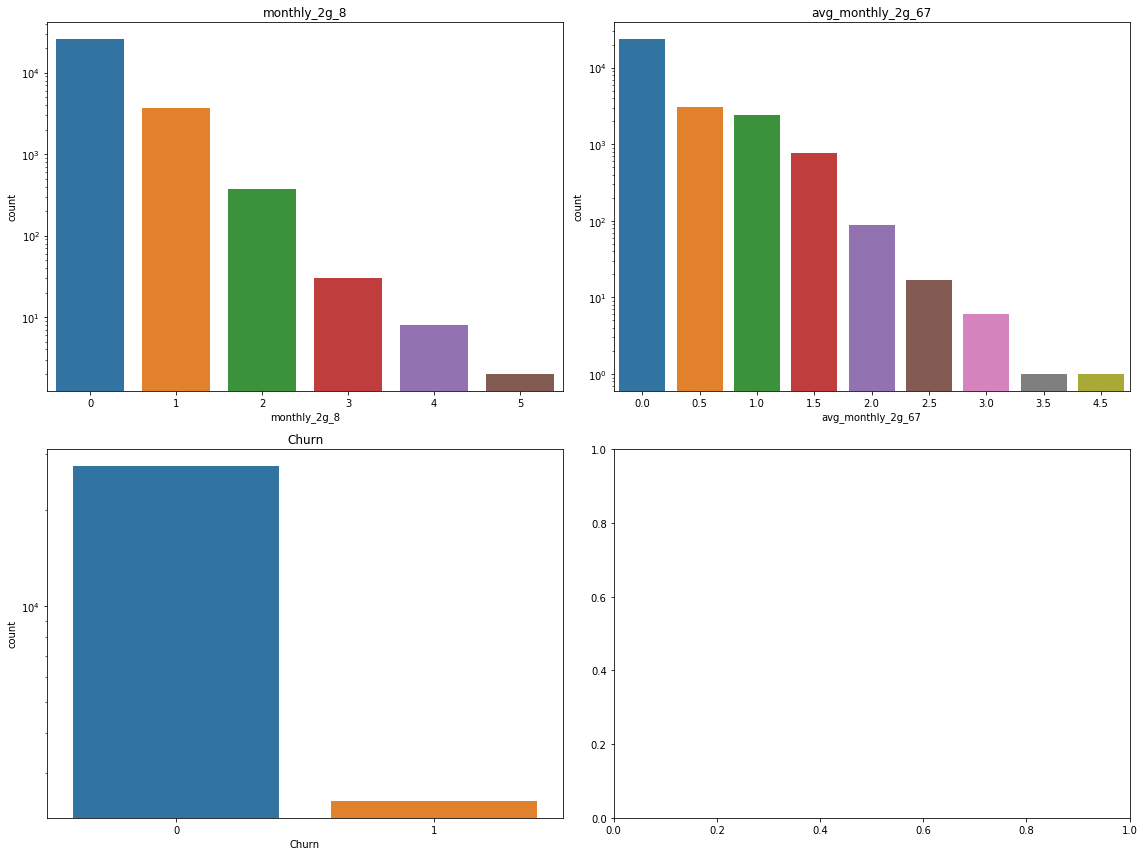

In [52]:
# Plotting Bar chart for data attributes
col_10=df.columns[df.nunique()<=10].tolist()  # Selecting columns that have less than 11 unique values for plotting using barchart
func_bar(*col_10,data_df=df)

### Box plot

In [0]:
#function for box plot
def bx_plot(*args,data): 
    
    m=math.ceil(len(args)/2)  # getting the length f arguments to determine the shape of subplots                   
    fig,axes = plt.subplots(m,2,squeeze=False, figsize = (16, 8*m))
    ax_li = axes.flatten()       # flattening the numpy array returned by subplots
    i=0
    for col in args:
        
        sns.boxplot(col, data, ax=ax_li[i])  # plotting the box plot
        ax_li[i].set_title(col)
        #ax_li[i].set_xscale('log')
        plt.tight_layout()
        i=i+1

In [54]:
# plotting the distribution for recharge amount 
col_rech = [col for col in df.columns if 'rech' in col]
col_rech


['total_rech_num_8',
 'total_rech_amt_8',
 'max_rech_amt_8',
 'total_rech_data_8',
 'avg_total_rech_amt_67',
 'avg_total_rech_num_67',
 'avg_max_rech_amt_67',
 'avg_total_rech_data_67',
 'avg_av_rech_amt_data_67']

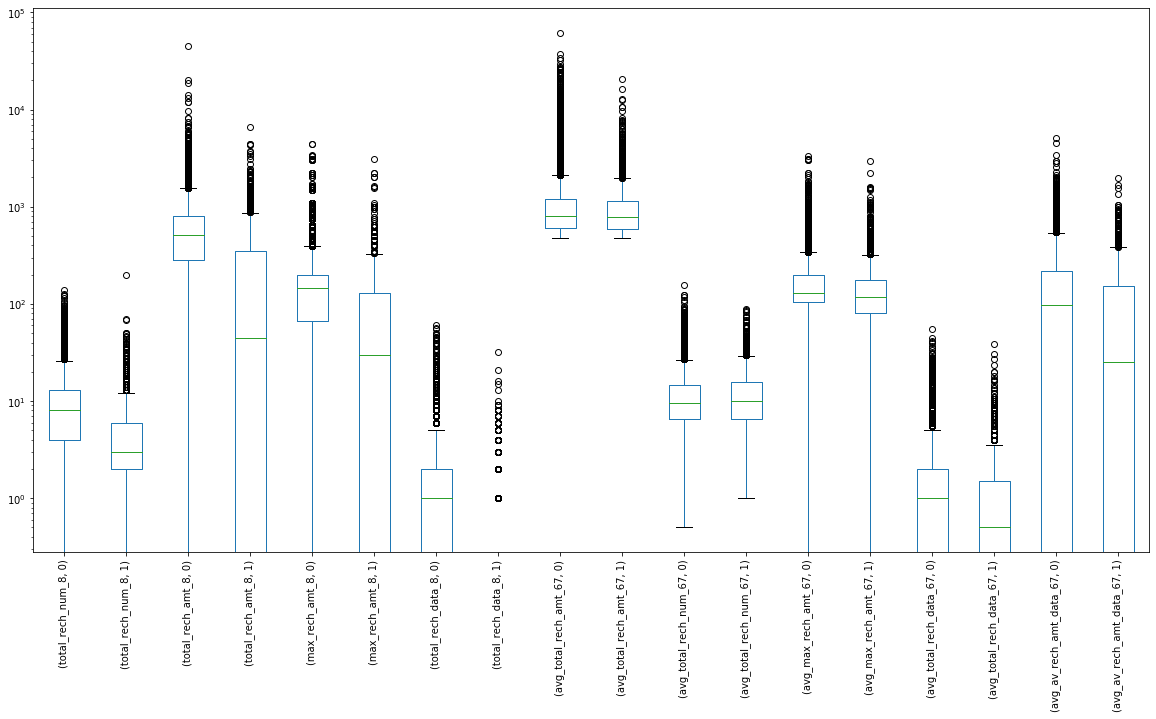

In [55]:
fig,axes = plt.subplots(1,1,squeeze=False, figsize = (20, 10))
ax=axes[0][0]

df.pivot(columns='Churn')[col_rech].plot(kind = 'box',ax=ax)

ax.xaxis.set_tick_params(rotation=90)
plt.yscale('log')
 

In [56]:
# Checking the data distribution of each attibute across multiple percentiles
df[col_rech].describe(percentiles=[.75,0.9,0.99,0.999,0.9999,.99999])

,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,total_rech_data_8,avg_total_rech_amt_67,avg_total_rech_num_67,avg_max_rech_amt_67,avg_total_rech_data_67,avg_av_rech_amt_data_67
count,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000
mean,9.972868,584.365454,160.144462,1.621913,1152.620628,11.784924,170.743275,1.760758,135.218053
std,9.274370,611.245907,173.207799,2.996010,1358.713982,8.634676,154.193137,2.706465,182.000971
min,0.000000,0.000000,0.000000,0.000000,478.000000,0.500000,0.000000,0.000000,0.000000
50%,8.000000,490.000000,130.000000,1.000000,800.000000,9.500000,128.000000,1.000000,92.000000
75%,13.000000,776.000000,198.000000,2.000000,1208.000000,14.500000,200.000000,2.000000,210.500000
90%,21.000000,1148.000000,252.000000,5.000000,1991.500000,22.000000,300.000000,5.000000,314.000000
99%,45.000000,2341.000000,951.000000,13.000000,6090.500000,44.500000,799.500000,12.000000,782.000000
99.9%,75.000000,5021.000000,2000.000000,28.000000,17408.500000,74.000000,1555.000000,23.500000,1638.000000
99.99%,122.000000,14000.000000,3299.000000,50.000000,32593.500000,118.000000,3010.000000,40.500000,2982.000000


Clearly there are outliers in the data that has to be removed. Outliers beyound 99.99 percentile are removed. 

In [57]:
q=df['total_rech_amt_8'].quantile(0.9999) 
df=df[df['total_rech_amt_8']<=q]
df.shape

(29997, 90)

In [0]:
# Checking for highly correlated columns
# function to eliminate redundant pairs
def redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()   # to ensure that duplicate pairs are not present
    cols = df.columns       # getting list of all solumns in dataframe  
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

# function to get highly correlated pairs
def get_top_abs_correlations(df, n):     
    cor = df.corr().abs().unstack()  # getting the absolute value of all correlation coefficienrs
    labels_to_drop = redundant_pairs(df)
    cor = cor.drop(labels=labels_to_drop).sort_values(ascending=False)
    return cor[0:n]

In [59]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(df[col_rech],10))


Top Absolute Correlations
total_rech_num_8        avg_total_rech_num_67      0.717505
total_rech_data_8       avg_total_rech_data_67     0.702747
max_rech_amt_8          avg_max_rech_amt_67        0.648081
avg_total_rech_amt_67   avg_av_rech_amt_data_67    0.632790
                        avg_total_rech_data_67     0.615741
total_rech_amt_8        max_rech_amt_8             0.532138
total_rech_data_8       avg_total_rech_amt_67      0.430680
total_rech_num_8        total_rech_amt_8           0.408284
avg_total_rech_data_67  avg_av_rech_amt_data_67    0.401791
total_rech_num_8        total_rech_data_8          0.327460
dtype: float64


In [0]:
#Columns with correlation more than 75% will be dropped

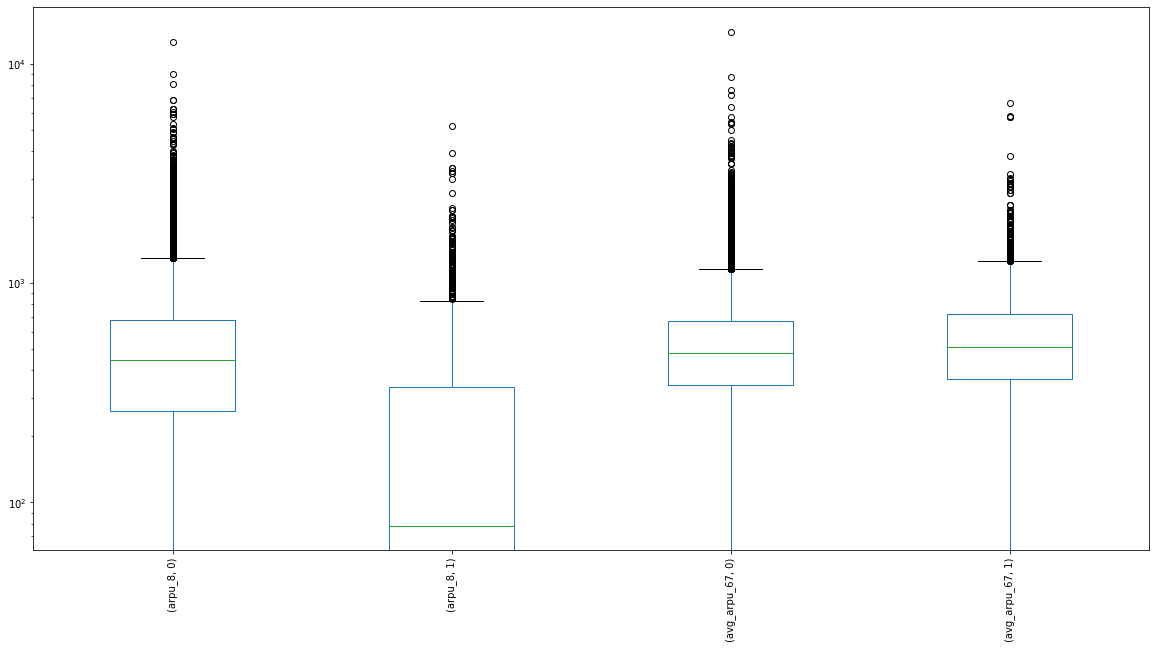

In [61]:
# plotting the distribution for arpu
col_arpu= [col for col in df.columns if 'arpu' in col]

fig,axes = plt.subplots(1,1,squeeze=False, figsize = (20, 10))
ax=axes[0][0]

df.pivot(columns='Churn')[col_arpu].plot(kind = 'box',ax=ax)

ax.xaxis.set_tick_params(rotation=90)
plt.yscale('log')
 

Clearly, the ARPU decreases for churned customers for the 8th month

In [62]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(df[col_arpu],4))

Top Absolute Correlations
arpu_8  avg_arpu_67    0.688261
dtype: float64


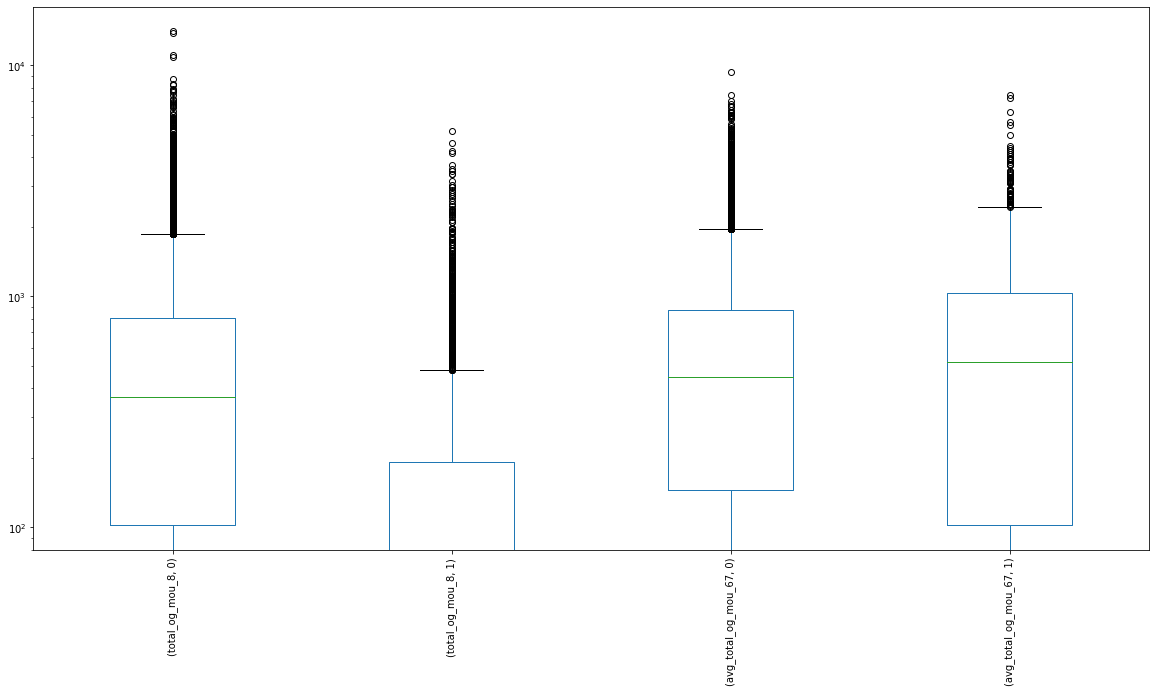

In [63]:
# plotting the distribution for outgoing calls
col_og = [col for col in df.columns if 'total_og' in col]
fig,axes = plt.subplots(1,1,squeeze=False, figsize = (20, 10))
ax=axes[0][0]

df.pivot(columns='Churn')[col_og].plot(kind = 'box',ax=ax)
ax.xaxis.set_tick_params(rotation=90)
plt.yscale('log')
 

The total outgoing calls decreases for the churned customers

In [64]:
og = [col for col in df.columns if 'og' in col]
print("Top Absolute Correlations")
print(get_top_abs_correlations(df[og],30))

Top Absolute Correlations
std_og_mou_8           total_og_mou_8           0.852557
avg_std_og_mou_67      avg_total_og_mou_67      0.835188
loc_og_mou_8           avg_loc_og_mou_67        0.824565
loc_og_t2t_mou_8       avg_loc_og_t2t_mou_67    0.811194
isd_og_mou_8           avg_isd_og_mou_67        0.801329
loc_og_t2m_mou_8       avg_loc_og_t2m_mou_67    0.797326
avg_loc_og_t2m_mou_67  avg_loc_og_mou_67        0.792615
loc_og_t2m_mou_8       loc_og_mou_8             0.788760
std_og_t2f_mou_8       avg_std_og_t2f_mou_67    0.776264
loc_og_t2t_mou_8       loc_og_mou_8             0.767340
std_og_t2m_mou_8       std_og_mou_8             0.763136
avg_loc_og_t2t_mou_67  avg_loc_og_mou_67        0.762653
loc_og_t2f_mou_8       avg_loc_og_t2f_mou_67    0.761180
std_og_t2t_mou_8       avg_std_og_t2t_mou_67    0.757286
avg_std_og_t2m_mou_67  avg_std_og_mou_67        0.754513
std_og_t2t_mou_8       std_og_mou_8             0.746404
std_og_mou_8           avg_std_og_mou_67        0.743040
avg_s

In [65]:
# Dropping columns with more than 75% correlation
df.drop(['std_og_mou_8','avg_std_og_mou_67','avg_loc_og_mou_67', 'avg_loc_og_t2t_mou_67','avg_isd_og_mou_67','avg_loc_og_t2m_mou_67','loc_og_t2m_mou_8',
         'avg_std_og_t2f_mou_67','avg_loc_og_t2f_mou_67','avg_std_og_t2t_mou_67','avg_std_og_mou_67'],axis=1,inplace=True)
df.shape

(29997, 80)

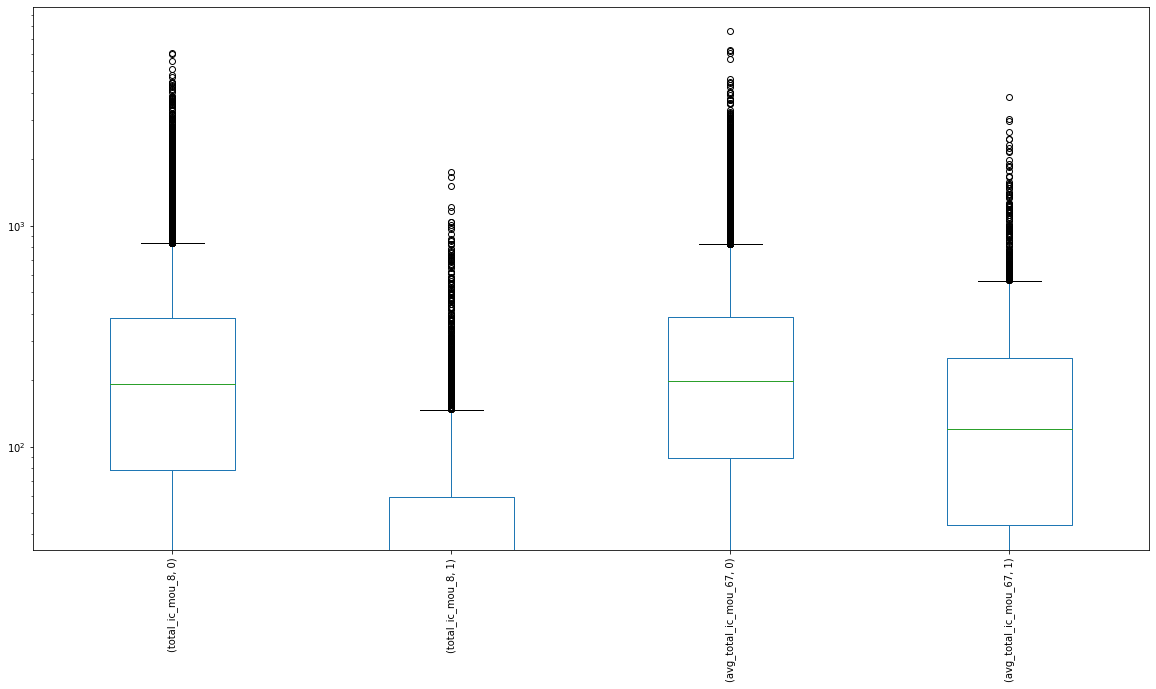

In [66]:
# plotting the distribution for incoming calls
col_ic = [col for col in df.columns if 'total_ic' in col]
fig,axes = plt.subplots(1,1,squeeze=False, figsize = (20, 10))
ax=axes[0][0]

df.pivot(columns='Churn')[col_ic].plot(kind = 'box',ax=ax)
ax.xaxis.set_tick_params(rotation=90)
plt.yscale('log')

Incoming calls gradually decrease over the  months for the churned customers

In [67]:
ic = [col for col in df.columns if 'ic' in col]
print("Top Absolute Correlations")
print(get_top_abs_correlations(df[ic],25))

Top Absolute Correlations
loc_ic_mou_8           total_ic_mou_8           0.896248
avg_loc_ic_mou_67      avg_total_ic_mou_67      0.894035
loc_ic_t2m_mou_8       loc_ic_mou_8             0.848857
std_ic_t2m_mou_8       std_ic_mou_8             0.845857
avg_loc_ic_t2m_mou_67  avg_loc_ic_mou_67        0.843443
loc_ic_mou_8           avg_loc_ic_mou_67        0.824140
avg_std_ic_t2m_mou_67  avg_std_ic_mou_67        0.817633
total_ic_mou_8         avg_total_ic_mou_67      0.806181
loc_ic_t2m_mou_8       avg_loc_ic_t2m_mou_67    0.796036
loc_ic_t2t_mou_8       avg_loc_ic_t2t_mou_67    0.791551
loc_ic_t2f_mou_8       avg_loc_ic_t2f_mou_67    0.773733
loc_ic_t2m_mou_8       total_ic_mou_8           0.768828
avg_loc_ic_t2m_mou_67  avg_total_ic_mou_67      0.757034
std_ic_t2f_mou_8       avg_std_ic_t2f_mou_67    0.741901
ic_others_8            avg_ic_others_67         0.740908
std_ic_mou_8           avg_std_ic_mou_67        0.739996
loc_ic_mou_8           avg_total_ic_mou_67      0.739800
total

In [68]:
# Dropping columns with more than 75% correlation
df.drop(['loc_ic_mou_8','avg_loc_ic_mou_67','std_ic_t2m_mou_8','avg_std_ic_mou_67','avg_loc_ic_t2m_mou_67','avg_loc_ic_t2t_mou_67',
         'avg_loc_ic_t2f_mou_67'],axis=1,inplace=True)
df.shape

(29997, 73)

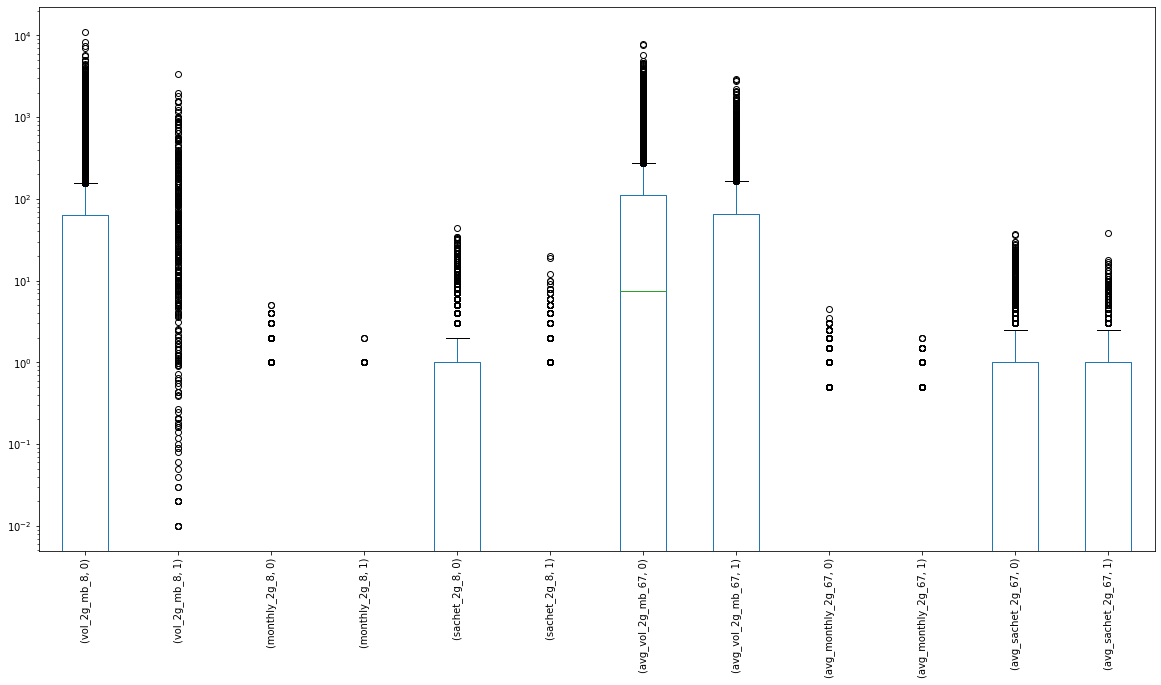

In [69]:
# plotting the distribution for  2g data
col_2g= [col for col in df.columns if '2g' in col]

fig,axes = plt.subplots(1,1,squeeze=False, figsize = (20, 10))
ax=axes[0][0]

df.pivot(columns='Churn')[col_2g].plot(kind = 'box',ax=ax)

ax.xaxis.set_tick_params(rotation=90)
plt.yscale('log')

Data usage decreases over the months for churned customers

In [70]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(df[col_2g],5))

Top Absolute Correlations
sachet_2g_8       avg_sachet_2g_67     0.716381
vol_2g_mb_8       avg_vol_2g_mb_67     0.652127
monthly_2g_8      avg_monthly_2g_67    0.604092
avg_vol_2g_mb_67  avg_monthly_2g_67    0.363790
vol_2g_mb_8       monthly_2g_8         0.313924
dtype: float64


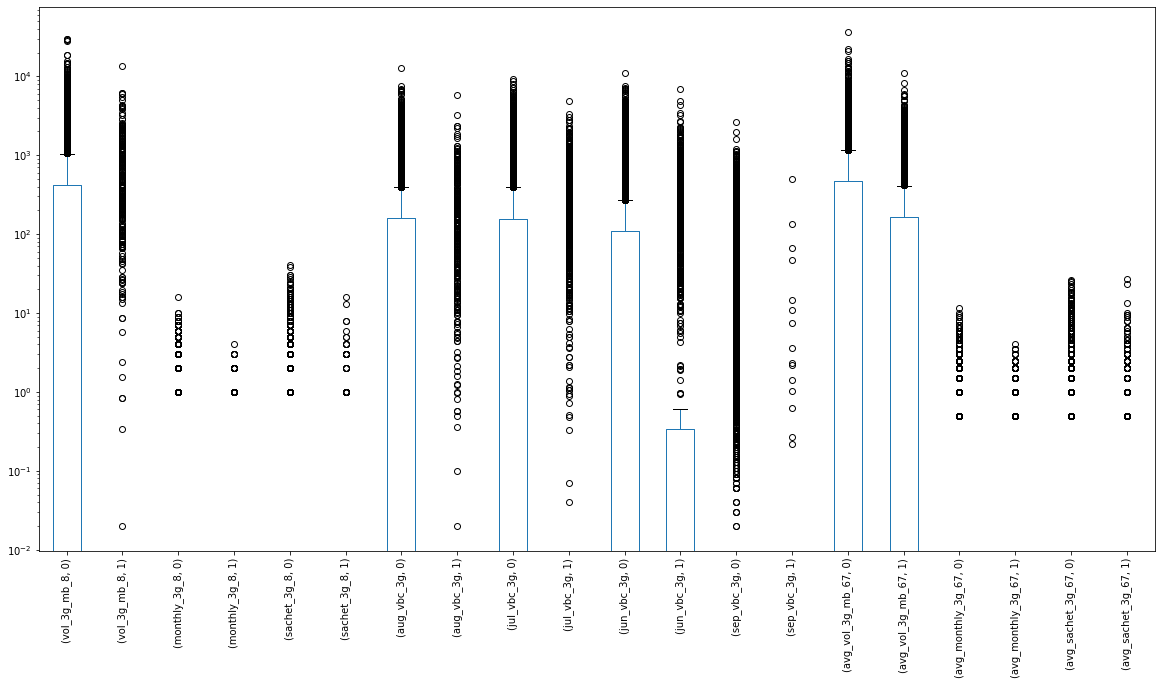

In [71]:
# plotting the distribution for  3g data
col_3g= [col for col in df.columns if '3g' in col]

fig,axes = plt.subplots(1,1,squeeze=False, figsize = (20, 10))
ax=axes[0][0]

df.pivot(columns='Churn')[col_3g].plot(kind = 'box',ax=ax)

ax.xaxis.set_tick_params(rotation=90)
plt.yscale('log')

Data usage decreases over the months for churned customers

In [72]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(df[col_3g],5))

Top Absolute Correlations
vol_3g_mb_8   avg_vol_3g_mb_67     0.751147
aug_vbc_3g    jul_vbc_3g           0.697300
monthly_3g_8  avg_monthly_3g_67    0.684379
jul_vbc_3g    jun_vbc_3g           0.667317
sachet_3g_8   avg_sachet_3g_67     0.647242
dtype: float64


In [73]:
df.drop('avg_vol_3g_mb_67',axis=1,inplace=True)
df.shape

(29997, 72)

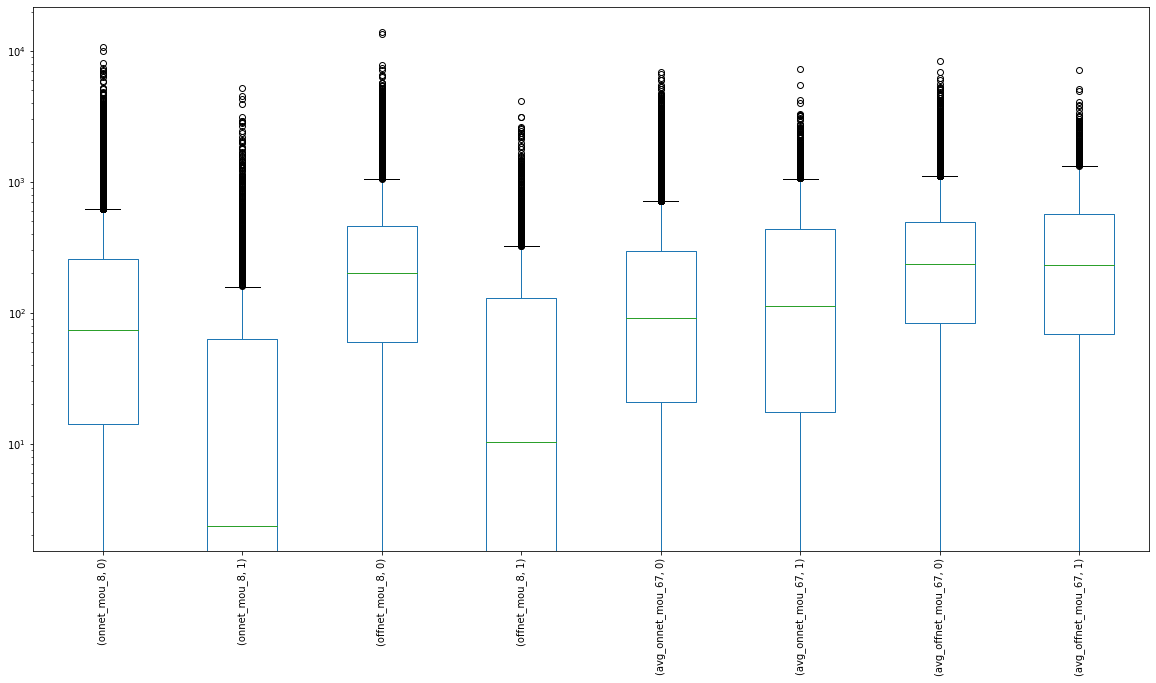

In [74]:
# plotting the distribution for onnet and offnet
col_on= [col for col in df.columns if 'net' in col]

fig,axes = plt.subplots(1,1,squeeze=False, figsize = (20, 10))
ax=axes[0][0]

df.pivot(columns='Churn')[col_on].plot(kind = 'box',ax=ax)

ax.xaxis.set_tick_params(rotation=90)
plt.yscale('log')

In [75]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(df[col_on],5))

Top Absolute Correlations
onnet_mou_8       avg_onnet_mou_67     0.764388
offnet_mou_8      avg_offnet_mou_67    0.722994
onnet_mou_8       offnet_mou_8         0.131502
                  avg_offnet_mou_67    0.083901
avg_onnet_mou_67  avg_offnet_mou_67    0.078037
dtype: float64


In [76]:
# Dropping columns with more than 75 % correlation
df.drop('avg_onnet_mou_67',axis=1,inplace=True)
df.shape

(29997, 71)

In [77]:
# Getting top correlation for entire dataframe
print("Top Absolute Correlations")
print(get_top_abs_correlations(df[df.columns.tolist()[1:]], 20))


Top Absolute Correlations
arpu_8                   total_rech_amt_8         0.942449
avg_total_rech_data_67   avg_sachet_2g_67         0.905255
total_rech_data_8        sachet_2g_8              0.900628
onnet_mou_8              std_og_t2t_mou_8         0.860666
offnet_mou_8             std_og_t2m_mou_8         0.853837
avg_offnet_mou_67        avg_std_og_t2m_mou_67    0.841641
total_ic_mou_8           avg_total_ic_mou_67      0.806181
loc_ic_t2m_mou_8         total_ic_mou_8           0.768828
loc_og_t2t_mou_8         loc_og_mou_8             0.767340
offnet_mou_8             total_og_mou_8           0.754659
std_ic_t2f_mou_8         avg_std_ic_t2f_mou_67    0.741901
ic_others_8              avg_ic_others_67         0.740908
avg_offnet_mou_67        avg_total_og_mou_67      0.735232
onnet_mou_8              total_og_mou_8           0.732647
avg_av_rech_amt_data_67  avg_monthly_3g_67        0.728308
total_og_mou_8           avg_total_og_mou_67      0.725193
offnet_mou_8             avg_o

In [78]:
# Dropping columns with more than 75 % correlation
col_to_drop=['arpu_8','avg_sachet_2g_67','sachet_2g_8','std_og_t2t_mou_8','offnet_mou_8','avg_std_og_t2m_mou_67',
             'loc_og_t2t_mou_8']
df.drop(col_to_drop,axis=1,inplace=True)
df.shape

(29997, 64)

In [0]:
# Splitting the data into train and test

In [0]:
# Putting feature variable to X
X = df.drop('Churn',axis=1)

# Putting response variable to y
y = df['Churn']

# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=100)

In [0]:
X_train.shape
cols=X_train.columns

In [0]:
# SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=100, ratio=1.0)
X_smt, y_smt = sm.fit_sample(X_train, y_train)

In [83]:
X_train = pd.DataFrame(X_smt)
y_train = pd.DataFrame(y_smt)
# rename the columns
X_train.columns =cols
y_train= y_train.rename(columns={ 0 : 'Churn'})
X_train.head()

,mobile_number,onnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,total_og_mou_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,std_ic_t2t_mou_8,std_ic_t2f_mou_8,std_ic_mou_8,total_ic_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,total_rech_data_8,vol_2g_mb_8,vol_3g_mb_8,monthly_2g_8,monthly_3g_8,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,avg_total_rech_amt_67,avg_arpu_67,avg_offnet_mou_67,avg_roam_ic_mou_67,avg_roam_og_mou_67,avg_loc_og_t2c_mou_67,avg_spl_og_mou_67,avg_og_others_67,avg_total_og_mou_67,avg_std_ic_t2t_mou_67,avg_std_ic_t2m_mou_67,avg_std_ic_t2f_mou_67,avg_total_ic_mou_67,avg_spl_ic_mou_67,avg_isd_ic_mou_67,avg_ic_others_67,avg_total_rech_num_67,avg_max_rech_amt_67,avg_last_day_rch_amt_67,avg_total_rech_data_67,avg_av_rech_amt_data_67,avg_vol_2g_mb_67,avg_monthly_2g_67,avg_monthly_3g_67,avg_sachet_3g_67
0,7.001454e+09,4.84,31.11,9.86,0.00,1.10,24.66,13.26,0.00,54.01,1.10,0.0,93.04,46.11,105.54,2.18,0.0,0.00,57.56,266.61,0.0,55.19,0.00,3.0,658.0,229.0,200.0,0.0,0.00,0.00,0.0,0.0,0.0,3651.0,0.00,0.00,0.00,0.0,1186.5,998.3205,155.450,27.81,10.255,3.200,4.275,0.000,152.185,0.000,25.185,0.00,394.750,0.000,197.245,1.005,6.5,428.5,216.5,0.0,0.0,0.00,0.0,0.0,0.0
1,7.001832e+09,148.59,0.00,0.00,20.99,0.00,324.64,0.00,0.00,0.00,0.00,0.0,324.64,494.24,608.13,23.54,0.0,0.33,6.04,1131.98,0.0,0.00,0.00,5.0,250.0,250.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,2792.0,564.03,399.40,507.20,0.0,706.0,464.1135,157.430,0.00,0.000,10.565,10.565,0.000,289.795,0.395,1.095,0.00,836.110,0.000,0.000,0.000,4.0,301.0,251.0,1.0,203.0,425.80,0.5,0.5,0.0
2,7.002244e+09,83.24,0.00,0.00,0.00,1.11,196.48,920.71,0.00,0.00,15.69,0.0,1190.46,48.48,198.79,0.91,0.0,0.00,28.43,276.63,0.0,0.00,0.00,5.0,676.0,169.0,169.0,0.0,0.00,0.00,0.0,0.0,0.0,1689.0,0.00,0.00,0.00,0.0,620.0,449.7650,836.420,0.00,0.000,2.305,2.305,0.225,953.625,10.630,48.610,4.79,298.445,0.000,0.000,0.000,7.5,169.0,139.5,0.0,0.0,0.00,0.0,0.0,0.0
3,7.000752e+09,697.44,22.81,23.56,18.96,2.38,1011.06,139.61,28.69,0.00,14.71,0.0,1228.93,1217.66,216.96,49.49,0.0,5.08,19.49,1503.63,0.0,0.00,0.00,10.0,650.0,130.0,130.0,0.0,0.00,0.00,0.0,0.0,0.0,1464.0,0.00,0.00,0.00,0.0,805.0,779.4150,335.445,19.88,16.755,0.000,15.970,0.000,1593.210,0.130,767.625,1.05,1044.720,0.075,0.000,0.000,11.5,120.0,55.0,0.0,0.0,0.00,0.0,0.0,0.0
4,7.000346e+09,23.89,0.00,0.00,3.58,0.00,93.68,0.00,0.00,0.00,1.50,0.0,107.06,236.61,189.46,56.99,0.0,0.00,0.00,496.44,0.0,0.00,13.36,6.0,304.0,154.0,30.0,1.0,57.56,392.11,1.0,0.0,0.0,279.0,262.76,406.66,121.27,0.0,670.5,447.7025,244.445,0.00,0.000,0.000,3.345,1.305,279.865,0.000,0.000,1.40,478.030,0.000,0.000,0.565,17.0,154.0,15.0,1.0,154.0,36.46,1.0,0.0,0.0


In [84]:
 # Scaling
scaler = StandardScaler()  
X1=X_train.drop('mobile_number',axis=1)
XT1=X_test.drop('mobile_number',axis=1)
#X.head()
col=X1.columns.tolist()
X1[col] = scaler.fit_transform(X1[col]) # scaling
XT1[col]= scaler.transform(XT1[col])
XT1.head()

,onnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,total_og_mou_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,std_ic_t2t_mou_8,std_ic_t2f_mou_8,std_ic_mou_8,total_ic_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,total_rech_data_8,vol_2g_mb_8,vol_3g_mb_8,monthly_2g_8,monthly_3g_8,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,avg_total_rech_amt_67,avg_arpu_67,avg_offnet_mou_67,avg_roam_ic_mou_67,avg_roam_og_mou_67,avg_loc_og_t2c_mou_67,avg_spl_og_mou_67,avg_og_others_67,avg_total_og_mou_67,avg_std_ic_t2t_mou_67,avg_std_ic_t2m_mou_67,avg_std_ic_t2f_mou_67,avg_total_ic_mou_67,avg_spl_ic_mou_67,avg_isd_ic_mou_67,avg_ic_others_67,avg_total_rech_num_67,avg_max_rech_amt_67,avg_last_day_rch_amt_67,avg_total_rech_data_67,avg_av_rech_amt_data_67,avg_vol_2g_mb_67,avg_monthly_2g_67,avg_monthly_3g_67,avg_sachet_3g_67
53991,-0.090911,-0.213512,-0.248120,0.453162,0.420563,0.937164,-0.233159,-0.122261,-0.081436,-0.057024,-0.02122,0.291661,0.606181,2.861789,0.132297,5.385486,-0.066093,5.651760,4.003617,-0.164207,-0.143479,-0.089457,-0.084664,0.585760,0.481362,1.072963,-0.023732,3.645238,-0.301372,2.849137,-0.288207,-0.156263,-0.991280,-0.327176,-0.374179,-0.376462,-0.118787,-0.011458,-0.180580,-0.196764,-0.255893,-0.314279,-0.334666,-0.438928,-0.198146,-0.431934,6.269319,0.979625,-0.032938,2.702127,-0.447852,-0.182122,-0.096648,-0.926890,1.275251,-0.171650,-0.036749,0.743436,2.173206,4.239547,-0.396170,-0.228419
8279,-0.427851,-0.173230,-0.203622,-0.249991,0.226990,-0.498986,-0.352468,-0.122261,-0.081436,-0.127912,-0.02122,-0.633987,-0.275230,-0.514341,-0.266541,0.125831,-0.113759,-0.125399,-0.519792,-0.164207,-0.143479,-0.089457,-0.084664,-0.709991,-0.596179,-0.528555,0.812389,0.440586,-0.301372,-0.289543,-0.288207,0.993812,-0.382754,-0.327176,-0.374179,-0.376462,-0.118787,-0.195826,-1.235063,-0.833272,-0.219290,-0.246026,2.644298,0.647794,-0.198146,-0.994879,-0.219743,-0.338391,-0.169920,-0.680872,-0.447852,-0.182122,-0.096648,-0.119699,-0.951932,-0.740683,1.599788,-0.148819,0.460452,-0.414505,-0.396170,-0.228419
61559,-0.450484,-0.213512,-0.248120,-0.249991,1.046448,-0.465575,-0.352468,-0.122261,-0.081436,0.697929,-0.02122,-0.597774,-0.317557,-0.375594,-0.266541,-0.174056,0.108435,-0.203107,-0.483926,-0.164207,-0.143479,-0.089457,2.314480,-0.056932,-0.627871,-0.328365,5.829120,-0.193218,1.404815,-0.289543,-0.288207,-0.156263,0.408567,1.288166,0.395943,0.114393,-0.118787,-0.049810,-1.297886,-0.853056,-0.255893,-0.314279,-0.334666,0.057793,-0.198146,-1.016657,-0.241576,-0.276079,-0.090516,-0.633900,-0.447852,-0.182122,-0.096648,-0.057607,-0.969197,-0.652784,1.804355,0.199768,-0.096608,-0.414505,-0.396170,-0.228419
49668,0.007746,0.816887,1.692192,-0.249991,-0.213388,-0.471200,-0.350498,-0.122261,-0.081436,-0.289181,-0.02122,-0.609110,-0.322008,-0.521768,-0.266541,-0.174056,-0.113759,-0.270628,-0.596833,-0.164207,-0.143479,-0.089457,-0.463477,-0.668527,-0.469409,-0.528555,-0.441793,-0.276354,-0.301372,-0.289543,-0.288207,-0.156263,-0.690555,-0.327176,-0.374179,-0.376462,-0.118787,0.098978,0.879259,0.073296,-0.255893,-0.314279,0.270356,-0.090457,-0.198146,2.041421,0.230236,-0.048609,-0.169920,-0.187485,6.092018,0.255940,-0.080314,0.687493,-0.527213,-0.060620,-0.445883,-0.168007,-0.438183,-0.414505,0.638324,-0.228419
93509,-0.421784,-0.046308,-0.185155,-0.146547,-0.213388,-0.457222,0.075783,-0.122261,-0.081436,-0.289181,-0.02122,-0.380730,-0.229262,-0.483058,-0.203458,-0.100341,-0.113759,-0.090422,-0.462459,-0.164207,-0.143479,-0.089457,-0.716018,-0.875847,-0.786333,-0.528555,-0.441793,-0.276354,-0.301372,-0.289543,-0.288207,-0.156263,-0.250670,-0.327176,-0.374179,-0.376462,-0.118787,-0.501256,-0.783767,0.868432,-0.255893,-0.314279,-0.334666,-0.444925,-0.198146,0.258549,0.010785,-0.085323,0.145438,-0.599972,-0.447852,-0.182122,-0.096648,-0.740615,0.58465

## PCA

In [85]:
from sklearn.decomposition import PCA
pca = PCA(random_state=100)
pca.fit(X1[col])

PCA(copy=True, iterated_power='auto', n_components=None, random_state=100,
    svd_solver='auto', tol=0.0, whiten=False)

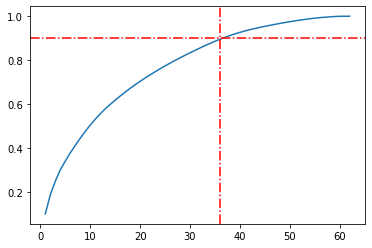

In [86]:
# Plotting the cumulative varoiance
var_cumu = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1,len(var_cumu)+1), var_cumu)
plt.axhline(y=.90, color='r', linestyle='-.')
plt.axvline(x=36, color='r', linestyle='-.')


In [0]:
#PCA with 36 components can explain about 90 % of variance

In [88]:
pc = PCA(n_components=36, random_state=100) # Selecting 4 PCs for further analysis
newdata = pc.fit_transform(X1[col])
newdata.shape

(38554, 36)

In [89]:
df_train_pca = pd.DataFrame(newdata)  # Creating a dataframe of PCs
df_train_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
0,1.218752,-0.468780,-2.708288,0.261823,0.050792,-0.607484,-0.820073,2.629800,0.427726,1.276761,-1.378432,-2.137742,-1.793063,-0.825004,-0.122412,-0.057054,0.434575,-0.209790,-0.931477,0.166259,1.142591,1.073807,0.900745,-1.645974,0.703275,0.543829,-0.069764,-0.437518,-0.316613,0.788946,-0.442361,0.408731,0.030214,0.699690,0.303356,0.077366
1,3.280789,0.753499,-1.531206,3.605228,-1.520421,-1.212936,0.405254,0.873577,-0.464559,-2.738320,0.801926,-0.849818,0.924755,-0.285193,0.452316,-0.323722,-1.158568,0.404871,-0.317068,0.908468,0.615862,0.626384,1.234971,0.110302,-0.141278,-0.320307,0.554596,-0.395669,-0.164050,1.624217,0.146113,-0.242552,-0.883969,0.929663,-1.046390,1.414796
2,0.579643,-2.233598,-0.493087,-0.146905,-1.120994,0.172510,-0.150709,-0.538916,-0.453342,0.362006,-0.428911,0.038846,0.336676,-0.291997,-1.413245,-1.299180,0.339337,0.593762,-0.125952,0.294932,-0.062699,0.470591,1.111006,0.467589,0.293782,-0.164821,-0.743981,-0.046957,0.052363,0.335129,-0.445768,-0.053454,0.022750,-0.110459,-0.013895,0.060099
3,5.180547,-4.622818,-0.066351,5.414068,0.655986,-0.228077,-1.027647,0.232856,-1.019732,-3.450871,2.103534,-0.613940,1.206421,0.958544,-0.368038,-2.482134,-1.843260,2.681129,-2.170027,0.071568,0.608723,-4.428775,-0.980977,-0.536696,-2.725916,1.887468,3.711841,-2.933196,-1.984543,3.291418,-0.679891,0.457871,-0.401674,-0.868080,1.111072,-0.891512
4,0.422100,0.992646,-0.117788,2.474933,-0.748767,-1.431798,0.565169,-0.606227,1.543331,-0.489044,1.233545,0.101330,0.800623,-0.777739,-0.447551,1.264957,-0.240059,0.317128,-0.673932,-1.803912,-0.255875,-0.149451,-0.170642,1.556255,-0.121215,-0.094972,0.477730,0.309956,-1.240924,-0.290211,0.635941,0.468684,0.128995,0.350866,0.224339,-0.375931


In [90]:
df_train_pca.shape

(38554, 36)

In [91]:
test_data = pc.transform(XT1[col])
df_test_pca = pd.DataFrame(test_data)
df_test_pca.shape

(9000, 36)

In [92]:
df_test_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
0,5.073562,-0.642587,-0.265667,7.236524,5.231360,-0.507535,3.303627,-4.904695,1.991679,-0.227986,-3.942905,-1.850438,1.354462,-0.184206,1.260048,0.675296,-0.521604,-0.067652,0.229773,-0.493540,-0.433156,1.916431,-0.036624,1.719811,-0.397287,-0.206874,-0.674519,0.727927,0.641835,-1.207205,0.620779,-0.188939,0.340360,-0.873829,-0.583856,0.889556
1,-2.443063,1.197958,1.811317,0.470830,0.463653,-0.525946,1.123283,0.886813,-0.876622,-0.226023,-0.791903,0.143980,-0.299140,-0.275747,0.089329,-0.639940,0.364518,-0.174048,0.034715,0.234990,0.265372,-0.072042,0.103784,0.001880,-0.244077,-0.544546,-0.276733,-0.506185,0.091947,0.487710,1.002479,-1.109147,-0.677356,0.855094,-0.655869,-0.247854
2,-0.618929,2.708793,3.429358,0.177375,0.468941,-0.928147,-0.327772,0.166481,-0.862535,-0.427830,-0.687891,1.852019,-1.488125,-0.497337,-0.816957,-0.746599,1.673456,-0.310290,-0.550684,-0.289099,0.101720,0.242925,0.026202,-0.791007,-0.206667,-1.093710,0.969947,0.981000,0.865147,0.266319,-0.167069,1.268618,-0.695522,0.677407,-1.064842,-2.656920
3,-1.327306,-1.147678,0.186756,-1.318411,0.293429,0.960249,0.111998,0.590824,0.937588,0.091019,0.789497,-0.457969,0.097734,3.513590,0.393678,1.762645,-1.947791,-0.564463,0.298016,-0.583492,-0.544379,0.104890,-2.679646,-0.758664,-0.889927,-0.225735,-2.068471,-0.175636,0.333689,1.882934,-1.602139,0.606320,0.669283,-0.169851,-0.789968,-0.525212
4,-2.200334,-0.568121,-0.944944,0.038949,-0.232500,0.779268,-0.312930,-0.268900,-0.234162,0.244123,0.050174,-0.114198,0.323119,-0.380191,-0.610785,-0.331531,0.073094,0.043163,0.114580,0.081612,-0.008329,0.383422,-0.041064,0.351403,0.103795,-0.045132,0.214192,-0.320547,0.433383,0.068693,0.172973,0.083047,0.197100,-0.350722,-0.175477,-0.284484


## Model Building

### Random Forest with PCA

Grid Search to Find Optimal Hyperparameters

In [0]:
# GridSearchCV to find optimal n_estimators
#from sklearn.model_selection import KFold

# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [10,12,15],
    'min_samples_leaf': range(50, 200, 50),
    'min_samples_split': range(50, 200, 50),
    'n_estimators': [100,150,200], 
    'max_features': [3,5, 8]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 1)

In [0]:
# Fit the grid search to the data
# commented as it takes long time
grid_search.fit(df_train_pca, y_train)  

Fitting 3 folds for each of 243 candidates, totalling 729 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.1min


In [0]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

We can get accuracy of 0.854749389301137 using {'max_depth': 15, 'max_features': 8, 'min_samples_leaf': 50, 'min_samples_split': 100, 'n_estimators': 100}


**Fitting the final model with the best parameters obtained from grid search.**

In [0]:
# model with the best hyperparameters
rfc = RandomForestClassifier(bootstrap=True,
                             max_depth=15,
                             min_samples_leaf=50, 
                             min_samples_split=100,
                             max_features=8,
                             n_estimators=100)

In [0]:
# fit
# fit
rfc.fit(df_train_pca, y_train)
# predict
predictions = rfc.predict(df_test_pca)
y_pred = rfc.predict_proba(df_test_pca)

In [95]:
# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
#print(classification_report(y_test,predictions))
#print(confusion_matrix(y_test,predictions))
conf = metrics.confusion_matrix(y_test, predictions )
conf

array([[7308,  971],
       [ 172,  549]])

In [96]:
TP = conf[1,1] # true positive 
TN = conf[0,0] # true negatives
FP = conf[0,1] # false positives
FN = conf[1,0] # false negatives
# Printing other performance meterics
print('Sensitivity/ Recall                  = ', TP / float(TP+FN))
print('Specificity                          = ',TN / float(TN+FP))
print('false positive rate                  = ',FP/ float(TN+FP))
print ('Positive predictive value/Precision  = ',TP / float(TP+FP))
print ('Negative predictive value            = ', TN / float(TN+FN))

Sensitivity/ Recall                  =  0.7614424410540915
Specificity                          =  0.8827153037806499
false positive rate                  =  0.11728469621935016
Positive predictive value/Precision  =  0.3611842105263158
Negative predictive value            =  0.9770053475935829


In [97]:
# evaluate predictions
roc = metrics.roc_auc_score(y_test, y_pred[:, 1])
print("AUC: %.2f%%" % (roc * 100.0))

AUC: 88.98%


## Logistic Regression with PCA


In [0]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()


In [99]:
# Building Logistic Model
X1_train_sm = stm.add_constant(df_train_pca)
log_m1 = stm.GLM(y_train,X1_train_sm, family = stm.families.Binomial())
res1 = log_m1.fit()
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                38554
Model:                            GLM   Df Residuals:                    38517
Model Family:                Binomial   Df Model:                           36
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15165.
Date:                Mon, 27 Jan 2020   Deviance:                       30330.
Time:                        16:24:42   Pearson chi2:                 3.87e+11
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4369      0.021    -20.846      0.000      -0.478      -0.396
0             -0.8366      0.012    -69.030      0.000      -0.860      -0.813
1             -0.0712      0.009     -7.601      0.000      -0.090      -0.053
2             -0.4231      0.013    -31.655      0.000      -0.449      -0.397
3             -0.5377      0.013    -42.822      0.000      -0.562      -0.513
4              0.3496      0.013     27.195      0.000       0.324       0.375
5              0.4992      0.013     37.101      0.000       0.473       0.526
6              0.1060      0.013      8.418      0.000       0.081       0.131
7              0.2945      0.019     15.725      0.000       0.258       0.331
8              0.0828      0.015      5.660      0.000       0.054       0.111
9              0.1992      0.018     10.842      0.000       0.163       0.235
10             0.1415      0.016      8.697      0.000       0.110       0.173
11            -0.7528      0.024    -31.623      0.000      -0.799      -0.706
12             0.2310      0.022     10.509      0.000       0.188       0.274
13            -0.1011      0.020     -5.176      0.000      -0.139      -0.063
14             0.5364      0.025     21.476      0.000       0.487       0.585
15            -0.5879      0.089     -6.584      0.000      -0.763      -0.413
16            -1.0581      0.103    -10.245      0.000      -1.261      -0.856
17            -1.2301      0.199     -6.170      0.000      -1.621      -0.839
18            -0.2009      0.081     -2.466      0.014      -0.361      -0.041
19            -1.2443      0.109    -11.406      0.000      -1.458      -1.030
20            -0.7631      0.170     -4.476      0.000      -1.097      -0.429
21            -0.5131      0.054     -9.441      0.000      -0.620      -0.407
22             0.6692      0.102      6.555      0.000       0.469       0.869
23            -0.2669      0.039     -6.877      0.000      -0.343      -0.191
24             0.1922      0.047      4.115      0.000       0.101       0.284
25            -0.1668      0.039     -4.284      0.000      -0.243      -0.090
26             0.1794      0.030      5.893      0.000       0.120       0.239
27             0.0632      0.029      2.195      0.028       0.007       0.120
28             0.3528      0.046      7.594      0.000       0.262       0.444
29             0.3967      0.042      9.406      0.000       0.314       0.479
30             0.0337      0.037      0.901      0.368      -0.040       0.107
31             0.2351      0.025      9.268      0.000       0.185       0.285
32             0.1270      0.029      4.435      0.000       0.071       0.183
33            -0.2138      0.025     -8.725      0.000      -0.262      -0.166
34             0.3166      0.024     13.196      0.000       0.270       0.364
35

In [0]:
y_train_pred = res1.predict(X1_train_sm).values.reshape(-1)

In [101]:
#Creating a dataframe with the actual churn flag and the predicted probabilities
y_train_pred_final = pd.DataFrame({'Churned':y_smt, 'Churn_Prob':y_train_pred})
y_train_pred_final['ind']=y_train_pred_final.index
y_train_pred_final.head()

,Churned,Churn_Prob,ind
0,0,0.724782,0
1,0,0.008951,1
2,0,0.141342,2
3,0,0.008153,3
4,0,0.100315,4


In [102]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Churned,Churn_Prob,ind,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.724782,0,1,1,1,1,1,1,1,1,0,0
1,0,0.008951,1,1,0,0,0,0,0,0,0,0,0
2,0,0.141342,2,1,1,0,0,0,0,0,0,0,0
3,0,0.008153,3,1,0,0,0,0,0,0,0,0,0
4,0,0.100315,4,1,1,0,0,0,0,0,0,0,0


In [103]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Churned, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.500000  1.000000  0.000000
0.1   0.1  0.702573  0.979872  0.425274
0.2   0.2  0.766354  0.957307  0.575401
0.3   0.3  0.805130  0.931265  0.678996
0.4   0.4  0.828293  0.899466  0.757120
0.5   0.5  0.838798  0.857758  0.819837
0.6   0.6  0.838123  0.803030  0.873217
0.7   0.7  0.819604  0.726565  0.912642
0.8   0.8  0.768662  0.591067  0.946257
0.9   0.9  0.642735  0.309229  0.976241


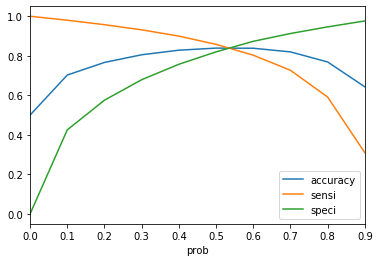

In [104]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [105]:
# Creating new column 'predicted' with 1 if conversion_Prob > 0.5 else 0
y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x >= 0.5 else 0)
y_train_pred_final.head()

,Churned,Churn_Prob,ind,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,predicted
0,0,0.724782,0,1,1,1,1,1,1,1,1,0,0,1
1,0,0.008951,1,1,0,0,0,0,0,0,0,0,0,0
2,0,0.141342,2,1,1,0,0,0,0,0,0,0,0,0
3,0,0.008153,3,1,0,0,0,0,0,0,0,0,0,0
4,0,0.100315,4,1,1,0,0,0,0,0,0,0,0,0


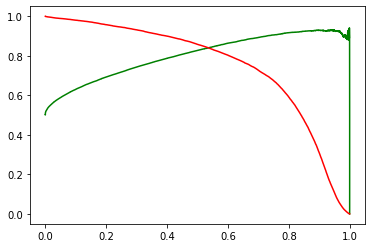

In [106]:
from sklearn.metrics import precision_recall_curve
y_train_pred_final.Churned, y_train_pred_final.predicted
p, r, thresholds = precision_recall_curve(y_train_pred_final.Churned, y_train_pred_final.Churn_Prob)
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

### Evaluating model performance

In [107]:
# Overall accuracy.
print("Accuracy is: ",metrics.accuracy_score(y_train_pred_final.Churned, y_train_pred_final.predicted))
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Churned, y_train_pred_final.predicted )
print(confusion)

Accuracy is:  0.8387975307361104
[[15804  3473]
 [ 2742 16535]]


In [108]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives
# Printing other performance meterics
print('Sensitivity/ Recall                  = ', TP / float(TP+FN))
print('Specificity                          = ',TN / float(TN+FP))
print('False positive rate                  = ',FP/ float(TN+FP))
print ('Positive predictive value/Precision  = ',TP / float(TP+FP))
print ('Negative predictive value            = ', TN / float(TN+FN))


Sensitivity/ Recall                  =  0.8577579498884681
Specificity                          =  0.8198371115837526
False positive rate                  =  0.18016288841624734
Positive predictive value/Precision  =  0.8264194322271091
Negative predictive value            =  0.8521514073115497


In [0]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

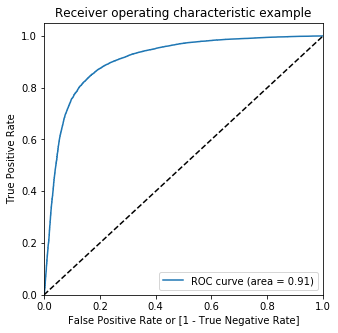

In [110]:
# Finding the ROC curve
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Churned, y_train_pred_final.Churn_Prob, drop_intermediate = False )
draw_roc(y_train_pred_final.Churned, y_train_pred_final.Churn_Prob)

In [111]:
X_test_sm = stm.add_constant(df_test_pca)
#Making predictions on the test set
y_test_pred = res1.predict(X_test_sm)

# Converting y_pred to a dataframe which is an array
y_pred_1 = pd.DataFrame(y_test_pred)
y_pred_1.head()

,0
0,0.001422
1,0.429782
2,0.010469
3,0.981876
4,0.860532


In [112]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)

# Putting CustID to index
y_test_df['CustID'] = y_test_df.index

# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)
y_pred_final= y_pred_final.rename(columns={ 0 : 'Churn_Prob'})
y_pred_final.head()

,Churn,CustID,Churn_Prob
0,0,53991,0.001422
1,1,8279,0.429782
2,0,61559,0.010469
3,1,49668,0.981876
4,1,93509,0.860532


In [113]:
# Final prediction
y_pred_final['final_predicted'] = y_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)

y_pred_final.head()

,Churn,CustID,Churn_Prob,final_predicted
0,0,53991,0.001422,0
1,1,8279,0.429782,0
2,0,61559,0.010469,0
3,1,49668,0.981876,1
4,1,93509,0.860532,1


In [114]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_pred_final.Churn, y_pred_final.final_predicted)

0.8267777777777777

In [115]:
confusion2 = metrics.confusion_matrix(y_pred_final.Churn, y_pred_final.final_predicted )
confusion2

array([[6839, 1440],
       [ 119,  602]])

In [116]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives
# Printing other performance meterics
print('Sensitivity/ Recall                  = ', TP / float(TP+FN))
print('Specificity                          = ',TN / float(TN+FP))
print('false positive rate                  = ',FP/ float(TN+FP))
print ('Positive predictive value/Precision  = ',TP / float(TP+FP))
print ('Negative predictive value            = ', TN / float(TN+FN))

Sensitivity/ Recall                  =  0.8349514563106796
Specificity                          =  0.8260659499939607
false positive rate                  =  0.17393405000603937
Positive predictive value/Precision  =  0.2948090107737512
Negative predictive value            =  0.9828973843058351


In [0]:
# A very low precision is observed for test set

In [0]:
fpr, tpr, thresholds = metrics.roc_curve( y_pred_final.Churn, y_pred_final.Churn_Prob, drop_intermediate = False )

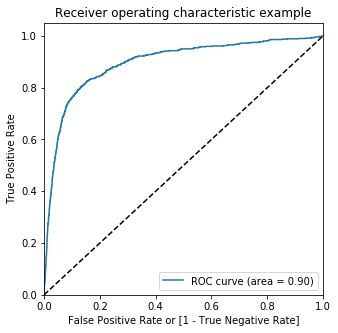

In [119]:
draw_roc(y_pred_final.Churn, y_pred_final.Churn_Prob)

### Logistic Regression using RFE

In [120]:
# initial model with all features

X_train_sm = stm.add_constant(X1)
log_m = stm.GLM(y_train,X_train_sm, family = stm.families.Binomial())
res = log_m.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                38554
Model:                            GLM   Df Residuals:                    38491
Model Family:                Binomial   Df Model:                           62
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14101.
Date:                Mon, 27 Jan 2020   Deviance:                       28203.
Time:                        16:30:10   Pearson chi2:                 2.90e+07
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.3949      0.022    -17.913      0.000      -0.438      -0.352
onnet_mou_8                 0.5419      0.097      5.569      0.000       0.351       0.733
roam_ic_mou_8              -0.0060      0.022     -0.274      0.784      -0.049       0.037
roam_og_mou_8               0.0121      0.029      0.418      0.676      -0.045       0.069
loc_og_t2f_mou_8         6.628e-05      0.022      0.003      0.998      -0.043       0.043
loc_og_t2c_mou_8            0.1213      0.021      5.901      0.000       0.081       0.162
loc_og_mou_8               -0.1802      0.050     -3.600      0.000      -0.278      -0.082
std_og_t2m_mou_8            0.4612      0.085      5.416      0.000       0.294       0.628
std_og_t2f_mou_8            0.0043      0.019      0.227      0.821      -0.033       0.042
isd_og_mou_8                0.0572      0.017      3.436      0.001       0.025       0.090
spl_og_mou_8               -0.0286      0.027     -1.052      0.293      -0.082       0.025
og_others_8                -0.7845      0.256     -3.060      0.002      -1.287      -0.282
total_og_mou_8             -1.4283      0.154     -9.288      0.000      -1.730      -1.127
loc_ic_t2t_mou_8         7334.1079    245.956     29.819      0.000    6852.043    7816.173
loc_ic_t2m_mou_8         1.055e+04    353.782     29.819      0.000    9856.128    1.12e+04
loc_ic_t2f_mou_8         2013.6162     67.527     29.819      0.000    1881.266    2145.967
std_ic_t2t_mou_8           -0.2645      0.049     -5.368      0.000      -0.361      -0.168
std_ic_t2f_mou_8           -0.0698      0.039     -1.796      0.073      -0.146       0.006
std_ic_mou_8             6584.5754    220.804     29.821      0.000    6151.807    7017.344
total_ic_mou_8          -1.789e+04    599.931    -29.822      0.000   -1.91e+04   -1.67e+04
spl_ic_mou_8                5.6877      0.204     27.944      0.000       5.289       6.087
isd_ic_mou_8             3066.4336    102.825     29.822      0.000    2864.900    3267.967
ic_others_8               569.6321     19.098     29.827      0.000     532.201     607.063
total_rech_num_8           -0.4201      0.036    -11.744      0.000      -0.490      -0.350
total_rech_amt_8            0.0023      0.052      0.045      0.964      -0.099       0.103
max_rech_amt_8              0.1114      0.030      3.713      0.000       0.053       0.170
last_day_rch_amt_8         -0.5068      0.025    -20.442      0.000      -0.555      -0.458
total_rech_data_8          -0.5731      0.036    -16.064      0.000      -0.643      -0.503
vol_2g_mb_8                -0.2499      0.029     -8.588      0.000      -0.307      -0.193
vol_3g_mb_8                -0.0470      0.034     -1.372      0.170      -0.114       0.020
monthly_2g_8               -0.2751      0.026  

In [0]:
logreg = LogisticRegression()

rfe = RFE(logreg,20)             # running RFE with 20 variables 
rfe = rfe.fit(X1, y_train)

In [123]:
# Checking the attribute names after RFE
rfe_cols = X1.columns[rfe.support_]
rfe_cols

Index(['onnet_mou_8', 'std_og_t2m_mou_8', 'og_others_8', 'total_og_mou_8',
       'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8', 'std_ic_mou_8',
       'total_ic_mou_8', 'spl_ic_mou_8', 'total_rech_num_8',
       'last_day_rch_amt_8', 'total_rech_data_8', 'monthly_2g_8',
       'monthly_3g_8', 'aon', 'sep_vbc_3g', 'avg_arpu_67',
       'avg_roam_ic_mou_67', 'avg_total_og_mou_67', 'avg_total_ic_mou_67'],
      dtype='object')

In [124]:
X1_train_sm = stm.add_constant(X1[rfe_cols])
log_m1 = stm.GLM(y_train,X1_train_sm, family = stm.families.Binomial())
res1 = log_m1.fit()
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                38554
Model:                            GLM   Df Residuals:                    38533
Model Family:                Binomial   Df Model:                           20
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14968.
Date:                Mon, 27 Jan 2020   Deviance:                       29936.
Time:                        16:34:40   Pearson chi2:                 2.26e+10
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.4846      0.021    -22.610      0.000      -0.527      -0.443
onnet_mou_8             0.8002      0.058     13.855      0.000       0.687       0.913
std_og_t2m_mou_8        0.6952      0.053     13.023      0.000       0.591       0.800
og_others_8            -0.6018      0.158     -3.815      0.000      -0.911      -0.293
total_og_mou_8         -1.9870      0.090    -22.166      0.000      -2.163      -1.811
loc_ic_t2t_mou_8       -0.6512      0.063    -10.398      0.000      -0.774      -0.528
loc_ic_t2m_mou_8       -0.7099      0.071    -10.046      0.000      -0.848      -0.571
std_ic_mou_8           -0.2410      0.046     -5.220      0.000      -0.331      -0.151
total_ic_mou_8         -0.7858      0.096     -8.172      0.000      -0.974      -0.597
spl_ic_mou_8           -0.3453      0.025    -14.066      0.000      -0.393      -0.297
total_rech_num_8       -0.4274      0.023    -18.854      0.000      -0.472      -0.383
last_day_rch_amt_8     -0.4519      0.020    -22.403      0.000      -0.491      -0.412
total_rech_data_8      -0.5738      0.025    -23.282      0.000      -0.622      -0.525
monthly_2g_8           -0.5128      0.022    -23.778      0.000      -0.555      -0.470
monthly_3g_8           -0.3634      0.021    -17.329      0.000      -0.404      -0.322
aon                    -0.2531      0.016    -15.919      0.000      -0.284      -0.222
sep_vbc_3g             -1.5710      0.122    -12.874      0.000      -1.810      -1.332
avg_arpu_67             0.4981      0.025     20.140      0.000       0.450       0.547
avg_roam_ic_mou_67      0.2344      0.020     11.867      0.000       0.196       0.273
avg_total_og_mou_67     0.2605      0.029      8.955      0.000       0.203       0.317
avg_total_ic_mou_67     0.6833      0.036     19.075      0.000       0.613       0.753
=======================================================================================
"""

In [0]:
y_train_pred = res1.predict(X1_train_sm).values.reshape(-1)

In [126]:
#Creating a dataframe with the actual churn flag and the predicted probabilities
y_train_pred_final = pd.DataFrame({'Churned':y_smt, 'Churn_Prob':y_train_pred})
y_train_pred_final['CustID'] = y_train_pred_final.index
y_train_pred_final.head()

,Churned,Churn_Prob,CustID
0,0,0.518874,0
1,0,0.002703,1
2,0,0.115563,2
3,0,0.000072,3
4,0,0.056275,4


In [127]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Churned,Churn_Prob,CustID,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.518874,0,1,1,1,1,1,1,0,0,0,0
1,0,0.002703,1,1,0,0,0,0,0,0,0,0,0
2,0,0.115563,2,1,1,0,0,0,0,0,0,0,0
3,0,0.000072,3,1,0,0,0,0,0,0,0,0,0
4,0,0.056275,4,1,0,0,0,0,0,0,0,0,0


In [128]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Churned, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.500000  1.000000  0.000000
0.1   0.1  0.708513  0.981117  0.435908
0.2   0.2  0.768792  0.958707  0.578876
0.3   0.3  0.806739  0.933755  0.679722
0.4   0.4  0.829071  0.899725  0.758417
0.5   0.5  0.841313  0.859470  0.823157
0.6   0.6  0.839628  0.807283  0.871972
0.7   0.7  0.824143  0.733102  0.915184
0.8   0.8  0.773979  0.598952  0.949007
0.9   0.9  0.646911  0.316284  0.977538


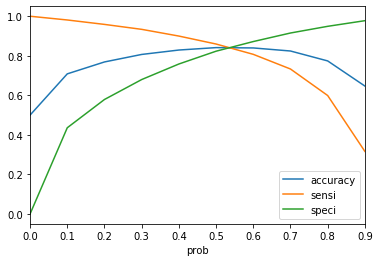

In [129]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])

In [130]:
# Creating new column 'predicted' with 1 if conversion_Prob > 0.6 else 0
y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x >= 0.5 else 0)
y_train_pred_final.head()

,Churned,Churn_Prob,CustID,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,predicted
0,0,0.518874,0,1,1,1,1,1,1,0,0,0,0,1
1,0,0.002703,1,1,0,0,0,0,0,0,0,0,0,0
2,0,0.115563,2,1,1,0,0,0,0,0,0,0,0,0
3,0,0.000072,3,1,0,0,0,0,0,0,0,0,0,0
4,0,0.056275,4,1,0,0,0,0,0,0,0,0,0,0


### Evaluating the preformance of the model

In [131]:
# Overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Churned, y_train_pred_final.predicted))
confusion = metrics.confusion_matrix(y_train_pred_final.Churned, y_train_pred_final.predicted )
print(confusion)

0.8413134823883385
[[15868  3409]
 [ 2709 16568]]


In [132]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives
# Printing other performance meterics
print('Sensitivity/ Recall                  = ', TP / float(TP+FN))
print('Specificity                          = ',TN / float(TN+FP))
print('false positive rate                  = ',FP/ float(TN+FP))
print ('Positive predictive value/Precision  = ',TP / float(TP+FP))
print ('Negative predictive value            = ', TN / float(TN+FN))

Sensitivity/ Recall                  =  0.8594698345178191
Specificity                          =  0.8231571302588577
false positive rate                  =  0.1768428697411423
Positive predictive value/Precision  =  0.8293537568203434
Negative predictive value            =  0.8541745168757066


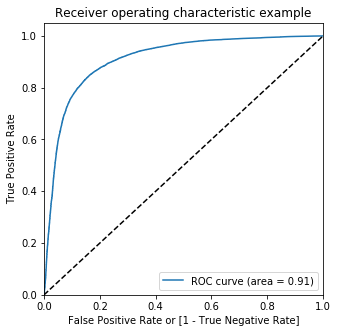

In [133]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Churned, y_train_pred_final.Churn_Prob, drop_intermediate = False )
draw_roc(y_train_pred_final.Churned, y_train_pred_final.Churn_Prob)

#### Prediction on Test Data

In [134]:
X_test_sm = stm.add_constant(XT1[rfe_cols])
#Making predictions on the test set
y_test_pred = res1.predict(X_test_sm)

# Converting y_pred to a dataframe which is an array
y_pred_1 = pd.DataFrame(y_test_pred)
y_pred_1.head()

,0
53991,0.000358
8279,0.548553
61559,0.015012
49668,0.977217
93509,0.808852


In [135]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)

# Putting CustID to index
y_test_df['CustID'] = y_test_df.index

# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)
y_pred_final= y_pred_final.rename(columns={ 0 : 'Churn_Prob'})
y_pred_final.head()

,Churn,CustID,Churn_Prob
0,0,53991,0.000358
1,1,8279,0.548553
2,0,61559,0.015012
3,1,49668,0.977217
4,1,93509,0.808852


In [136]:
y_pred_final['final_predicted'] = y_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)

y_pred_final.head()

,Churn,CustID,Churn_Prob,final_predicted
0,0,53991,0.000358,0
1,1,8279,0.548553,1
2,0,61559,0.015012,0
3,1,49668,0.977217,1
4,1,93509,0.808852,1


In [137]:
# Overall accuracy.
print(metrics.accuracy_score(y_pred_final.Churn, y_pred_final.final_predicted))
confusion = metrics.confusion_matrix(y_pred_final.Churn, y_pred_final.final_predicted )
print(confusion)

0.8278888888888889
[[6849 1430]
 [ 119  602]]


In [138]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives
# Printing other performance meterics
print('Sensitivity/ Recall                  = ', TP / float(TP+FN))
print('Specificity                          = ',TN / float(TN+FP))
print('false positive rate                  = ',FP/ float(TN+FP))
print ('Positive predictive value/Precision  = ',TP / float(TP+FP))
print ('Negative predictive value            = ', TN / float(TN+FN))

Sensitivity/ Recall                  =  0.8349514563106796
Specificity                          =  0.8272738253412247
false positive rate                  =  0.1727261746587752
Positive predictive value/Precision  =  0.296259842519685
Negative predictive value            =  0.9829219288174512


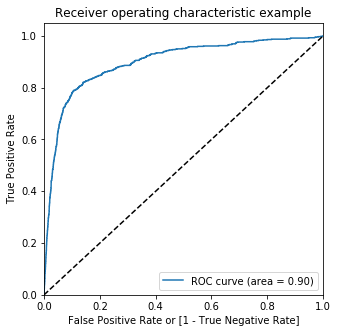

In [139]:
fpr, tpr, thresholds = metrics.roc_curve( y_pred_final.Churn, y_pred_final.Churn_Prob, drop_intermediate = False )
draw_roc(y_pred_final.Churn, y_pred_final.Churn_Prob)

In [140]:
# Important features
rfe_cols

Index(['onnet_mou_8', 'std_og_t2m_mou_8', 'og_others_8', 'total_og_mou_8',
       'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8', 'std_ic_mou_8',
       'total_ic_mou_8', 'spl_ic_mou_8', 'total_rech_num_8',
       'last_day_rch_amt_8', 'total_rech_data_8', 'monthly_2g_8',
       'monthly_3g_8', 'aon', 'sep_vbc_3g', 'avg_arpu_67',
       'avg_roam_ic_mou_67', 'avg_total_og_mou_67', 'avg_total_ic_mou_67'],
      dtype='object')

## XGBoost with PCA

In [142]:
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import gc # for deleting unused variables
# fit model on training data with default hyperparameters
model = XGBClassifier()
model.fit(df_train_pca, y_smt)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [143]:
# make predictions for test data
# use predict_proba since we need probabilities to compute auc
y_pred = model.predict_proba(df_test_pca)
y_pred[:10]

array([[0.9183114 , 0.08168856],
       [0.7518403 , 0.2481597 ],
       [0.9606752 , 0.03932482],
       [0.06397724, 0.93602276],
       [0.0855245 , 0.9144755 ],
       [0.7039833 , 0.29601666],
       [0.8230406 , 0.17695943],
       [0.44330293, 0.5566971 ],
       [0.8027084 , 0.19729161],
       [0.47073203, 0.52926797]], dtype=float32)

In [144]:
# evaluate predictions
roc = metrics.roc_auc_score(y_test, y_pred[:, 1])
print("AUC: %.2f%%" % (roc * 100.0))

AUC: 89.04%


In [0]:
# hyperparameter tuning with XGBoost

# creating a KFold object 
folds = 3

# specify range of hyperparameters
param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]}          


# specify model
xgb_model = XGBClassifier(max_depth=2, n_estimators=200)

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

In [0]:
# Fit the grid search to the data
# commented as it takes long time
#grid_search.fit(df_train_pca, y_train) 

In [148]:
# fit the model
model_cv.fit(df_train_pca, y_train)    

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  2.5min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=2, min_child_weight=1,
                                     missing=None, n_estimators=200, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.2, 0.6],
                         'subsample': [0.3, 0.6, 0.9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_scor

In [0]:
# printing the optimal accuracy score and hyperparameters
#print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

In [151]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,6.367536,0.013794,0.079642,0.000404,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.924612,0.934807,0.931706,0.930375,0.004267,5,0.943811,0.938290,0.941076,0.941059,0.002254
1,8.497560,0.004329,0.080605,0.000664,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.924417,0.936448,0.931555,0.930807,0.004940,3,0.944704,0.940455,0.941815,0.942325,0.001772
2,9.005939,0.014614,0.080087,0.001800,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.924934,0.935003,0.931532,0.930489,0.004176,4,0.945523,0.940343,0.941318,0.942394,0.002248
3,6.352710,0.008453,0.083503,0.004937,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.923928,0.935506,0.929793,0.929743,0.004727,6,0.954682,0.950190,0.951322,0.952065,0.001908
4,8.512416,0.014854,0.079809,0.000391,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.932347,0.941574,0.938338,0.937420,0.003823,2,0.961223,0.957889,0.959966,0.959693,0.001375
5,9.101382,0.039730,0.080044,0.001248,0.6,0.9,"{'learning_rate': 0.6, 'subsample': 0.9}",0.933505,0.944133,0.939479,0.939039,0.004350,1,0.962306,0.959973,0.961071,0.961117,0.000953


In [152]:
# convert parameters to int for plotting on x-axis
cv_results['param_learning_rate'] = cv_results['param_learning_rate'].astype('float')
#cv_results['param_max_depth'] = cv_results['param_max_depth'].astype('float')
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,6.367536,0.013794,0.079642,0.000404,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.924612,0.934807,0.931706,0.930375,0.004267,5,0.943811,0.938290,0.941076,0.941059,0.002254
1,8.497560,0.004329,0.080605,0.000664,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.924417,0.936448,0.931555,0.930807,0.004940,3,0.944704,0.940455,0.941815,0.942325,0.001772
2,9.005939,0.014614,0.080087,0.001800,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.924934,0.935003,0.931532,0.930489,0.004176,4,0.945523,0.940343,0.941318,0.942394,0.002248
3,6.352710,0.008453,0.083503,0.004937,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.923928,0.935506,0.929793,0.929743,0.004727,6,0.954682,0.950190,0.951322,0.952065,0.001908
4,8.512416,0.014854,0.079809,0.000391,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.932347,0.941574,0.938338,0.937420,0.003823,2,0.961223,0.957889,0.959966,0.959693,0.001375


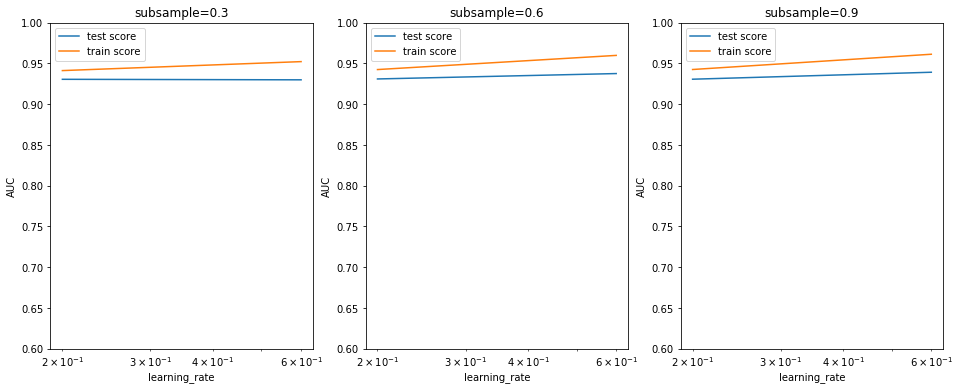

In [153]:
# # plotting
plt.figure(figsize=(16,6))

param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]} 


for n, subsample in enumerate(param_grid['subsample']):
    

    # subplot 1/n
    plt.subplot(1,len(param_grid['subsample']), n+1)
    df = cv_results[cv_results['param_subsample']==subsample]

    plt.plot(df["param_learning_rate"], df["mean_test_score"])
    plt.plot(df["param_learning_rate"], df["mean_train_score"])
    plt.xlabel('learning_rate')
    plt.ylabel('AUC')
    plt.title("subsample={0}".format(subsample))
    plt.ylim([0.60, 1])
    plt.legend(['test score', 'train score'], loc='upper left')
    plt.xscale('log')

In [154]:
#### haven't chosen the optimum
# chosen hyperparameters
# 'objective':'binary:logistic' outputs probability rather than label, which we need for auc
params = {'learning_rate': 0.2,
          'max_depth': 2, 
          'n_estimators':200,
          'subsample':0.6,
         'objective':'binary:logistic'}

# fit model on training data
model = XGBClassifier(params = params)
model.fit(df_train_pca, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic',
              params={'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 200,
                      'objective': 'binary:logistic', 'subsample': 0.6},
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

In [155]:
# predict
y_pred = model.predict_proba(df_test_pca)
y_pred[:10]

array([[0.9183114 , 0.08168856],
       [0.7518403 , 0.2481597 ],
       [0.9606752 , 0.03932482],
       [0.06397724, 0.93602276],
       [0.0855245 , 0.9144755 ],
       [0.7039833 , 0.29601666],
       [0.8230406 , 0.17695943],
       [0.44330293, 0.5566971 ],
       [0.8027084 , 0.19729161],
       [0.47073203, 0.52926797]], dtype=float32)

In [156]:
# roc_auc
auc = metrics.roc_auc_score(y_test, y_pred[:, 1])
auc

0.8904162211125553

In [157]:
# feature importance
importance = dict(zip(df_train_pca.columns, model.feature_importances_))
importance

{0: 0.23846568,
 1: 0.015770713,
 2: 0.053154774,
 3: 0.058530565,
 4: 0.05215168,
 5: 0.06076783,
 6: 0.045217138,
 7: 0.025929688,
 8: 0.012986376,
 9: 0.014447175,
 10: 0.033598065,
 11: 0.04940374,
 12: 0.04649261,
 13: 0.013253822,
 14: 0.03035896,
 15: 0.014034848,
 16: 0.023172932,
 17: 0.030591069,
 18: 0.012670319,
 19: 0.011375907,
 20: 0.0070599406,
 21: 0.005899799,
 22: 0.009109016,
 23: 0.008567645,
 24: 0.008998855,
 25: 0.0077620875,
 26: 0.0075364085,
 27: 0.007901098,
 28: 0.009404273,
 29: 0.019217664,
 30: 0.014710476,
 31: 0.00995456,
 32: 0.010489527,
 33: 0.0074224374,
 34: 0.008632621,
 35: 0.014959709}

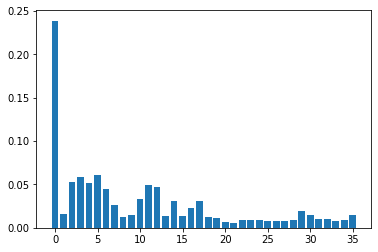

In [158]:
# plot
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

In [159]:
y_pred_fin = model.predict(df_test_pca)

conf = metrics.confusion_matrix(y_test, y_pred_fin )
conf

array([[7119, 1160],
       [ 158,  563]])

In [160]:
TP = conf[1,1] # true positive 
TN = conf[0,0] # true negatives
FP = conf[0,1] # false positives
FN = conf[1,0] # false negatives
# Printing other performance meterics
print('Sensitivity/ Recall                  = ', TP / float(TP+FN))
print('Specificity                          = ',TN / float(TN+FP))
print('false positive rate                  = ',FP/ float(TN+FP))
print ('Positive predictive value/Precision  = ',TP / float(TP+FP))
print ('Negative predictive value            = ', TN / float(TN+FN))

Sensitivity/ Recall                  =  0.7808599167822469
Specificity                          =  0.8598864597173572
false positive rate                  =  0.14011354028264283
Positive predictive value/Precision  =  0.3267556587347649
Negative predictive value            =  0.9782877559433832


## Model Results

Model Accuracy is better along with Sensitivity and Specificity while using Logic Regression along with PCA.
Model which is built with probablity of 0.6 or greater yielded Better results.

Area under the curve also resulted in 0.91

# Important Predictive variables which decide Churn are as follows:

1. total_og_mou_8
2. sep_vbc_3g
3. onnet_mou_8
4. loc_ic_t2m_mou_8
5. std_og_t2m_mou_8
6. avg_total_ic_mou_67
7. loc_ic_t2t_mou_8
8. og_others_8

## Recommended Strategy

Based on the above variables, reduced usage of the mobile either for call or data is a clear indication of churn.

Hence on any month, if the usage of customer reduces or go below the average usage in previous month, then we do the following:
1. Roll out offers to retain them
2. Assign a dedicated customer service specialist to understand the reason for leaving and bring the issue to closure in case of any pending problems reported by customer.

## Predictor Plot

In [0]:
## Summary Table

# Feature               # Coefficient
# total_og_mou_8        # -1.98
# sep_vbc_3g            # -1.57
# onnet_mou_8           # 0.800
# loc_ic_t2m_mou_8      # -0.70
# std_og_t2m_mou_8      # 0.69
# avg_total_ic_mou_67   # 0.68
# loc_ic_t2t_mou_8      # -0.65
# og_others_8           # -0.60